### Model Selection for Jail Population Forecasting

This notebook will explore major time series models to forecast jail population for 12 months in the future. I will consider ARIMA, exponential smoothing, linear regressions among other methods and guage the strength of each model on a standard accuracy method.

### Step 1: Import data and aggregate

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import boto3
from io import StringIO
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf,adfuller, kpss,range_unit_root_test # BDS for inped
from statsmodels.tsa.stattools import q_stat #Compute Ljung-Box Q Statistic.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy
%matplotlib inline

In [20]:
def check_file_existence(bucket_name,folder_name,file_name):
    """
    Function checks whether or not a specified file exists in its 
    designated location. Returns True if the file exists, otherwise False. 
    """
    try:
        s3_client = boto3.client('s3')
        s3_client.head_object(Bucket=bucket_name, Key=folder_name + file_name)
        return True
    except:
        return False

def get_file(bucket_name,folder_name,file_name): 
    """
    Function checks whether or not a specified file exists in its 
    designated location. If the file exists, the function retreives it from the 
    designated s3 bucket. 
    """
    if check_file_existence(bucket_name,folder_name,file_name):
        try:
            #get the merged file and save as df
            print('Trying to get object from bucket')
            s3_client = boto3.client('s3')
            file_content = s3_client.get_object(Bucket = bucket_name, Key = folder_name + file_name)['Body'].read().decode('utf-8')
            print('Got file contents from AWS S3')
            file_df = pd.read_csv(StringIO(file_content))
            print('Saved file contents as dataframe')
            return file_df
        except Exception as e:
            return e

In [21]:
bucket_name = 'doc-daily-inmates-in-custody'
folder_name = 'merged_files/'
file_name = 'agg_daily_pop.csv'

adp_df = get_file(bucket_name, folder_name, file_name)
adp_df.head()

Trying to get object from bucket
Got file contents from AWS S3
Saved file contents as dataframe


,snapshot_date,race_A,race_B,race_I,race_O,race_U,race_W,gender_F,gender_Gender Unknown,gender_M,population_group_Awaiting Transfer to State Prison,population_group_Jail Sentence,population_group_Miscellaneous,population_group_Parole Violations,population_group_Pretrial Detention,bradh_N,bradh_Y,Total Population,snapshot_month,snapshot_year
0,2021-07-26,105,3484,9,1648,33,648,295,20,5612,110,236,135,1042,4404,3017,2910,5927,7,2021
1,2021-07-27,106,3469,9,1642,31,643,296,18,5586,101,236,136,1038,4389,2997,2903,5900,7,2021
2,2021-07-28,106,3478,9,1648,31,640,292,18,5602,110,239,134,1038,4391,3007,2905,5912,7,2021
3,2021-07-29,108,3470,9,1649,34,638,291,22,5595,99,242,147,1036,4384,3014,2894,5908,7,2021
4,2021-07-30,108,3455,9,1630,33,638,285,21,5567,107,241,139,1026,4360,2981,2892,5873,7,2021


In [22]:
#aggregate to 30 day intervals
#set data type
adp_df['snapshot_date'] = pd.to_datetime(adp_df['snapshot_date'])
#get latest snapshot date
max_date = adp_df['snapshot_date'].max()
#aggregate to 30 day periods
interval_data = adp_df.resample('30D', on='snapshot_date',origin = max_date,closed='right',label = 'right').mean().round().fillna(0).reset_index()
interval_data = interval_data.rename(columns = {'snapshot_date':'End Date','Total Population':'ADP'})
interval_data['Start Date'] = interval_data['End Date'] - pd.to_timedelta(29, unit='D')

#display just date of the start/end date columns localize to specific timezone or altar will assume UTC in graph
interval_data['Start Date'] = interval_data['Start Date'].dt.tz_localize('America/New_York')
interval_data['End Date'] = interval_data['End Date'].dt.tz_localize('America/New_York')

interval_data.head()

,End Date,race_A,race_B,race_I,race_O,race_U,race_W,gender_F,gender_Gender Unknown,gender_M,...,population_group_Jail Sentence,population_group_Miscellaneous,population_group_Parole Violations,population_group_Pretrial Detention,bradh_N,bradh_Y,ADP,snapshot_month,snapshot_year,Start Date
0,2021-08-19 00:00:00-04:00,106.0,3481.0,9.0,1660.0,28.0,644.0,290.0,16.0,5621.0,...,243.0,134.0,1022.0,4431.0,3042.0,2885.0,5927.0,8.0,2021.0,2021-07-21 00:00:00-04:00
1,2021-09-18 00:00:00-04:00,103.0,3545.0,11.0,1702.0,29.0,643.0,297.0,17.0,5719.0,...,239.0,115.0,1026.0,4560.0,3143.0,2891.0,6034.0,9.0,2021.0,2021-08-20 00:00:00-04:00
2,2021-10-18 00:00:00-04:00,99.0,3370.0,12.0,1629.0,26.0,586.0,270.0,13.0,5439.0,...,130.0,119.0,799.0,4557.0,2970.0,2752.0,5722.0,9.0,2021.0,2021-09-19 00:00:00-04:00
3,2021-11-17 00:00:00-05:00,91.0,3282.0,11.0,1548.0,24.0,545.0,255.0,12.0,5234.0,...,118.0,131.0,651.0,4463.0,2783.0,2718.0,5501.0,10.0,2021.0,2021-10-19 00:00:00-04:00
4,2021-12-17 00:00:00-05:00,102.0,3226.0,13.0,1535.0,23.0,506.0,244.0,10.0,5151.0,...,137.0,146.0,551.0,4434.0,2733.0,2672.0,5405.0,12.0,2021.0,2021-11-18 00:00:00-05:00


In [23]:
#lets only look at the total population
_30day_pop_tot = interval_data[['Start Date','End Date','ADP']]
_30day_pop_tot.head()

,Start Date,End Date,ADP
0,2021-07-21 00:00:00-04:00,2021-08-19 00:00:00-04:00,5927.0
1,2021-08-20 00:00:00-04:00,2021-09-18 00:00:00-04:00,6034.0
2,2021-09-19 00:00:00-04:00,2021-10-18 00:00:00-04:00,5722.0
3,2021-10-19 00:00:00-04:00,2021-11-17 00:00:00-05:00,5501.0
4,2021-11-18 00:00:00-05:00,2021-12-17 00:00:00-05:00,5405.0


In [24]:
_30day_pop_tot.tail()

,Start Date,End Date,ADP
26,2023-09-09 00:00:00-04:00,2023-10-08 00:00:00-04:00,6187.0
27,2023-10-09 00:00:00-04:00,2023-11-07 00:00:00-05:00,6178.0
28,2023-11-08 00:00:00-05:00,2023-12-07 00:00:00-05:00,6148.0
29,2023-12-08 00:00:00-05:00,2024-01-06 00:00:00-05:00,6038.0
30,2024-01-07 00:00:00-05:00,2024-02-05 00:00:00-05:00,6142.0


In [25]:
len(_30day_pop_tot)

31

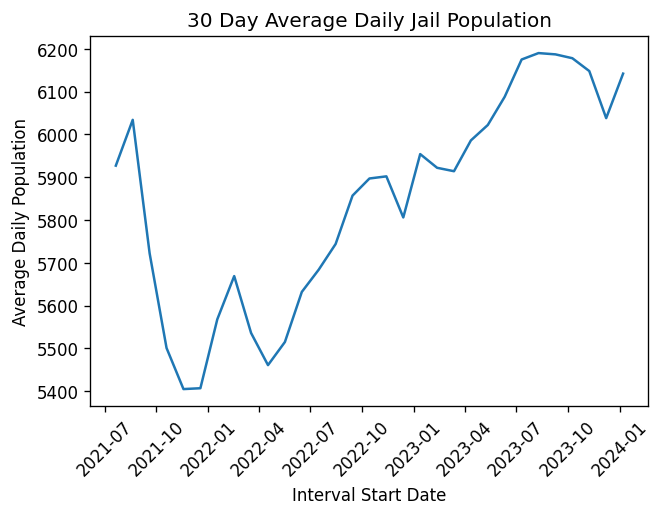

In [26]:
# Create the line plot
plt.figure(figsize = (6,4))

plt.plot(_30day_pop_tot['Start Date'], _30day_pop_tot['ADP'])
plt.xticks(rotation=45)  # Set the x-axis tick labels

plt.xlabel('Interval Start Date')
# Set the y-axis label
plt.ylabel('Average Daily Population')

# Set the plot title
plt.title('30 Day Average Daily Jail Population')
# Display the plot
plt.show()

### Step 2: ARIMA Model

* Investigate the seasonal decomposition of the timeseries of ADP

* Investigate the ACF and PACF and differencing of the series

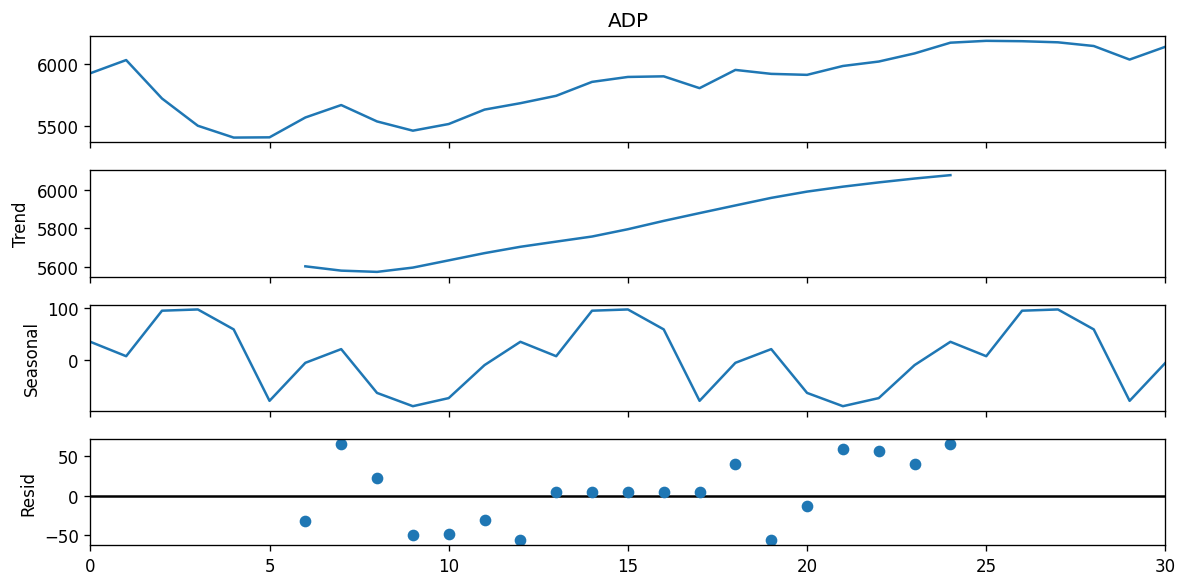

In [27]:
results = seasonal_decompose(_30day_pop_tot['ADP'],model='additive',period=12)
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
results.plot()
plt.show()

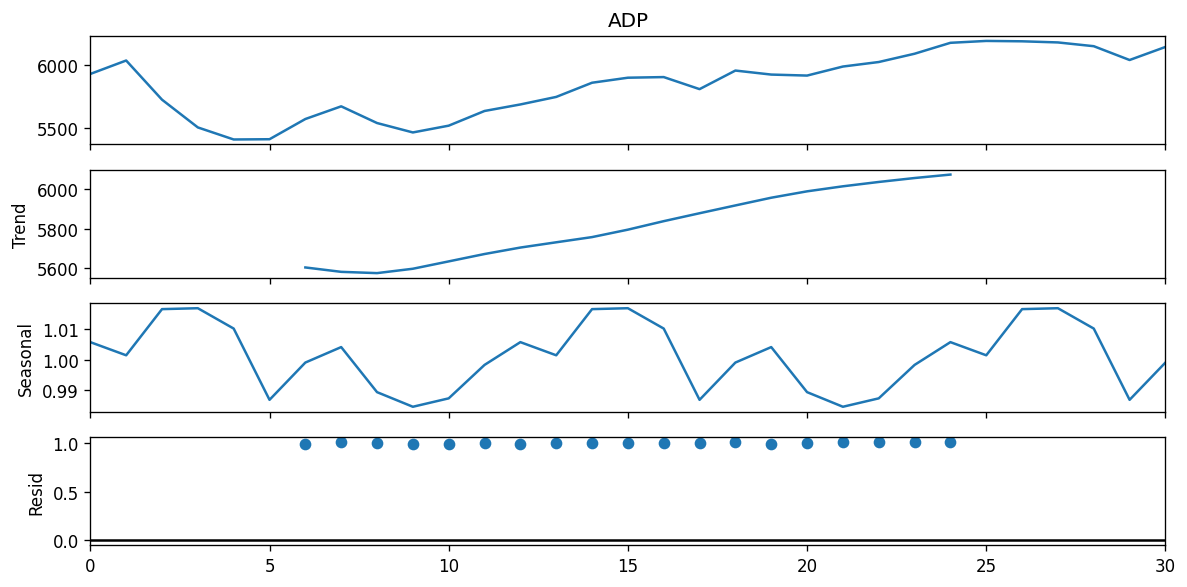

In [28]:
results = seasonal_decompose(_30day_pop_tot['ADP'],model='multiplicative',period=12)
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
results.plot()
plt.show()

Multiplicative models are recommended for time series with variance that changes over time. I am going to investigate the distribution of the ADP to see if it is normally distributed or not and compare it to the logarithm of the ADP.

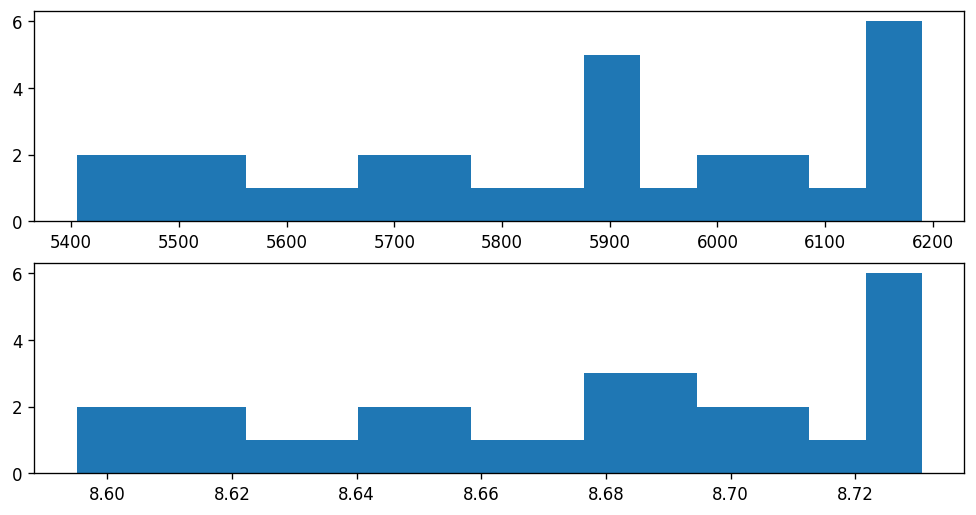

In [29]:
fig, ax = plt.subplots(2)
ax[0].hist(_30day_pop_tot['ADP'], bins = 15)
ax[1].hist(np.log(_30day_pop_tot['ADP']), bins = 15)
plt.show()

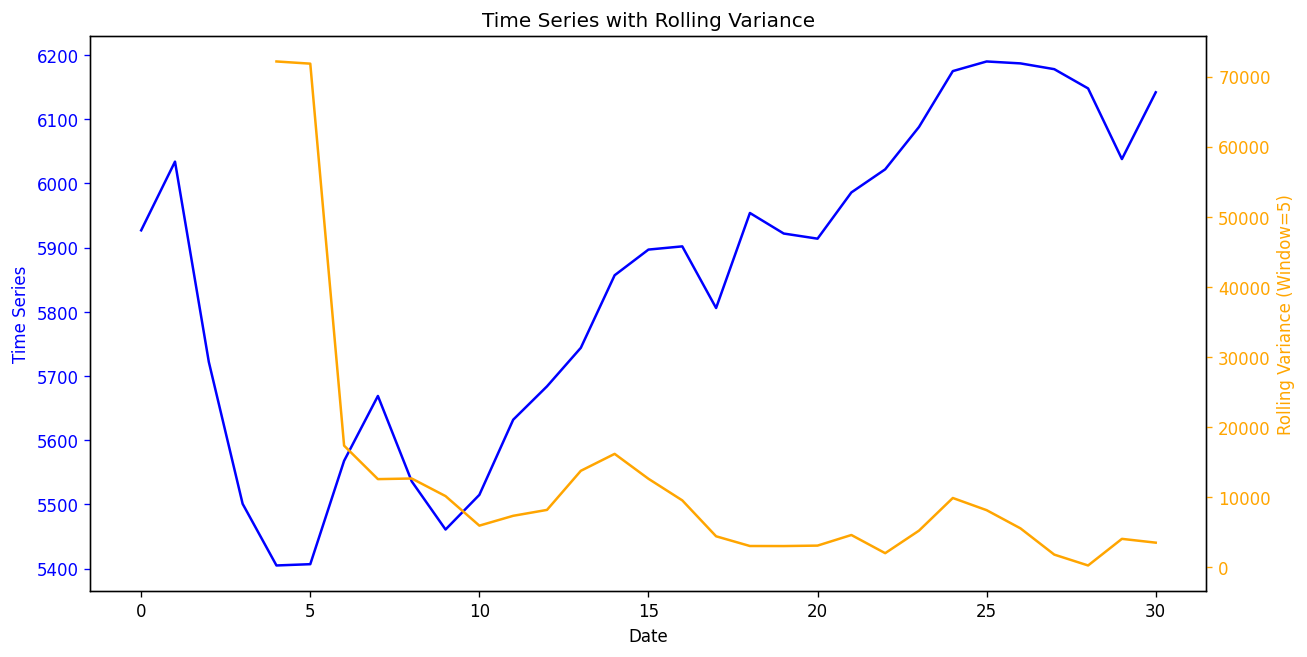

In [30]:
# Calculate the rolling variance with a window of 5 data points
rolling_variance = _30day_pop_tot['ADP'].rolling(window=5).var()

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the time series on the left y-axis
ax1.plot(_30day_pop_tot['ADP'], label='Time Series', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Time Series', color='blue')
ax1.tick_params('y', colors='blue')

# Create a twin axis on the right for rolling variance
ax2 = ax1.twinx()
ax2.plot(rolling_variance, label='Rolling Variance (Window=5)', color='orange')
ax2.set_ylabel('Rolling Variance (Window=5)', color='orange')
ax2.tick_params('y', colors='orange')

plt.title('Time Series with Rolling Variance')
plt.show()

Based on the plot above, the variance over time seems relatively stable if we don't account for the beginning of the series, if not it is decreasing over time. There may be a use case to exclude the beginning of our data from the time series training as it is anomalous to the great dataset due to the passing of Less is More Act.

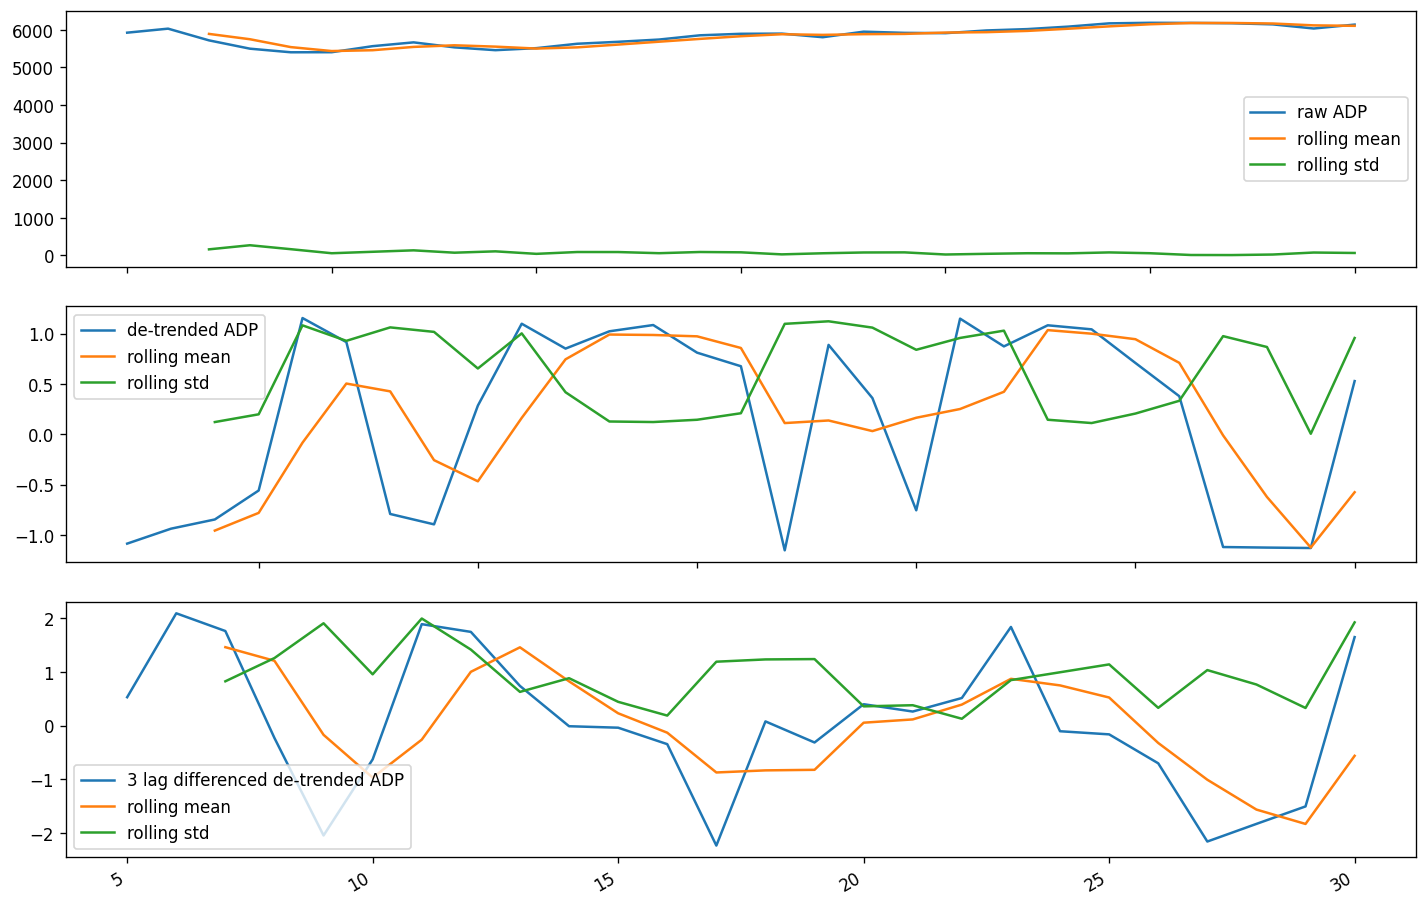

In [31]:
z_data = (_30day_pop_tot['ADP'] - _30day_pop_tot['ADP'].rolling(window=3).mean()) / _30day_pop_tot['ADP'].rolling(window=3).std()
zp_data = z_data - z_data.shift(3)


fig, ax = plt.subplots(3,figsize=(12, 9))
ax[0].plot(_30day_pop_tot.index, _30day_pop_tot.ADP, label='raw ADP')
ax[0].plot(_30day_pop_tot.ADP.rolling(window=3).mean(), label="rolling mean")
ax[0].plot(_30day_pop_tot.ADP.rolling(window=3).std(), label="rolling std")
ax[0].legend()

ax[1].plot(_30day_pop_tot.index, z_data, label="de-trended ADP")
ax[1].plot(z_data.rolling(window=3).mean(), label="rolling mean")
ax[1].plot(z_data.rolling(window=3).std(), label="rolling std")
ax[1].legend()

ax[2].plot(_30day_pop_tot.index, zp_data, label="3 lag differenced de-trended ADP")
ax[2].plot(zp_data.rolling(window=3).mean(), label="rolling mean")
ax[2].plot(zp_data.rolling(window=3).std(), label="rolling std")
ax[2].legend()

plt.tight_layout()
fig.autofmt_xdate()

Text(0.5, 1.0, 'ADP detrended by subtracting the trend component')

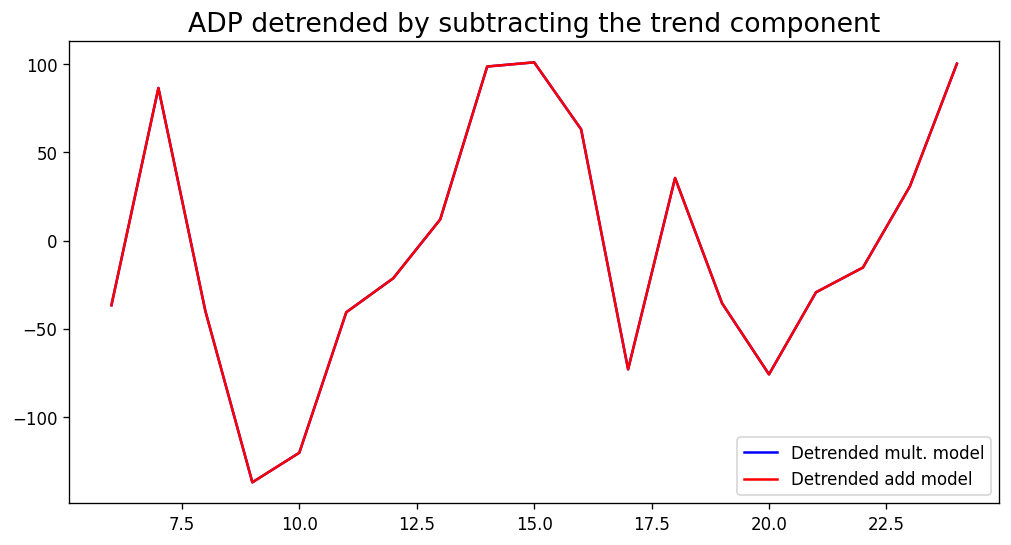

In [32]:
# Using statmodels: Subtracting the Trend Component
result_mul = seasonal_decompose(_30day_pop_tot['ADP'], model='multiplicative', period=12)
detrended_mul = _30day_pop_tot['ADP'].values - result_mul.trend
result_add = seasonal_decompose(_30day_pop_tot['ADP'], model='additive', period=12)
detrended_add = _30day_pop_tot['ADP'].values - result_add.trend

plt.plot(detrended_mul, color = 'b',label = 'Detrended mult. model')
plt.plot(detrended_add, color = 'r',label = 'Detrended add model')
plt.legend()
plt.title('ADP detrended by subtracting the trend component', fontsize=16)

### Determine stationality

Text(0.5, 1.0, 'Partial Autocorrelation')

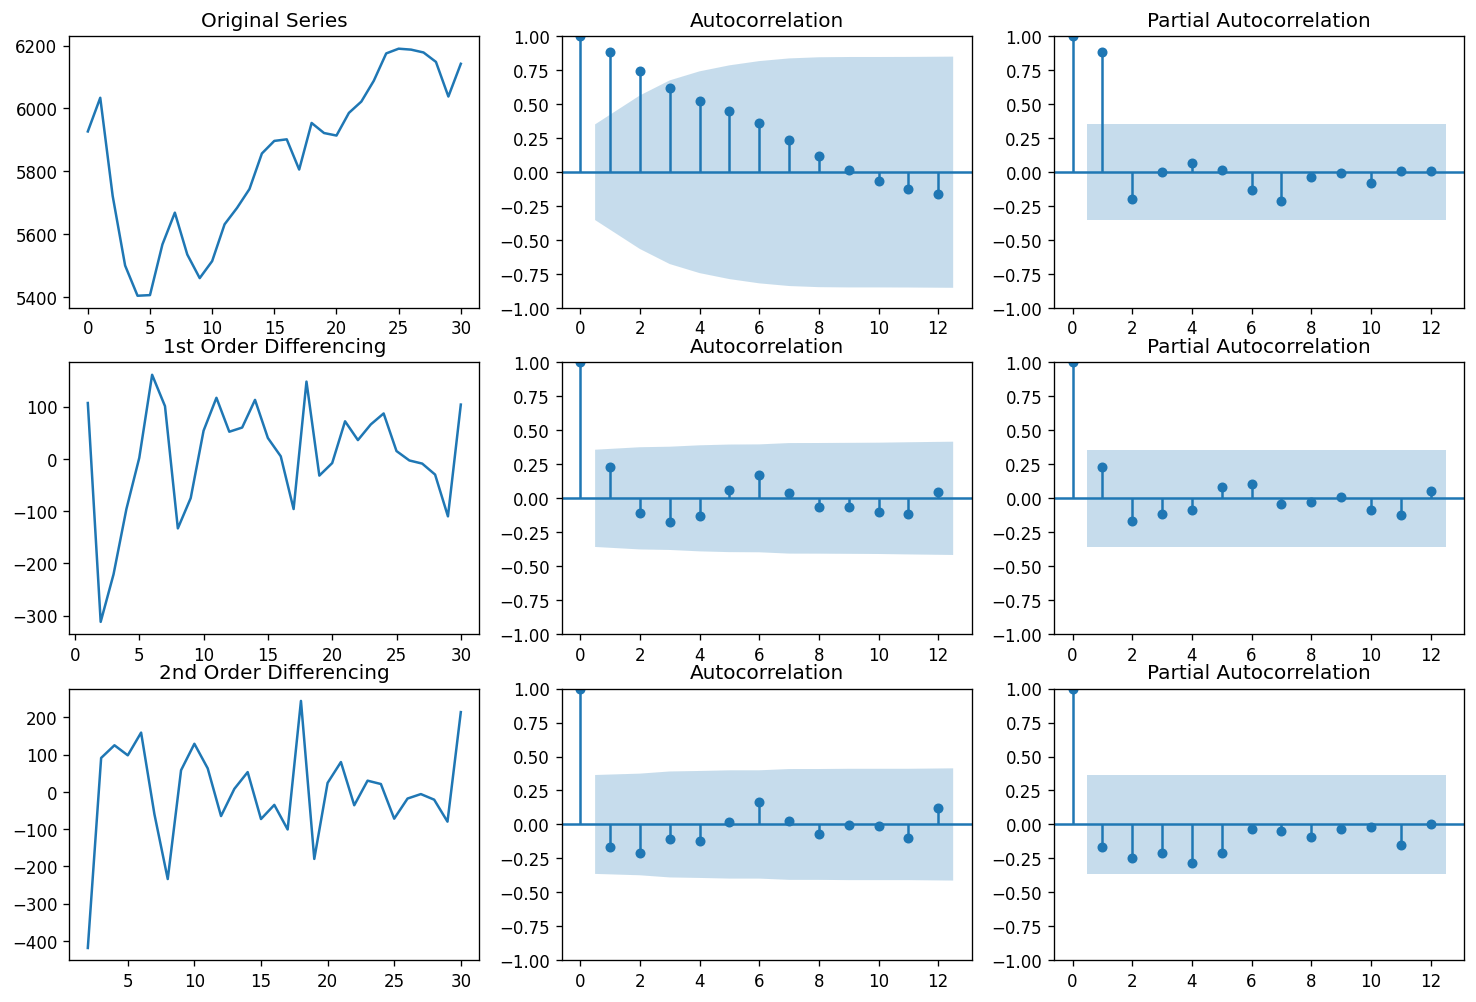

In [33]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 3)
axes[0, 0].plot(_30day_pop_tot['ADP']); axes[0, 0].set_title('Original Series')

plot_acf(_30day_pop_tot['ADP'], lags = 12, ax = axes[0, 1])
axes[0, 1].set_title('Autocorrelation')

plot_pacf(_30day_pop_tot['ADP'], lags = 12, ax=axes[0, 2])
axes[0, 2].set_title('Partial Autocorrelation')


# 1st Differencing
axes[1, 0].plot(_30day_pop_tot['ADP'].diff()); axes[1, 0].set_title('1st Order Differencing')

plot_acf(_30day_pop_tot['ADP'].diff().dropna(), lags = 12, ax = axes[1, 1])
axes[1, 1].set_title('Autocorrelation')

plot_pacf(_30day_pop_tot['ADP'].diff().dropna(), lags = 12, ax=axes[1, 2])
axes[1, 2].set_title('Partial Autocorrelation')

# 2nd Differencing
axes[2, 0].plot(_30day_pop_tot['ADP'].diff().dropna().diff().dropna()); axes[2, 0].set_title('2nd Order Differencing')

plot_acf(_30day_pop_tot['ADP'].diff().dropna().diff().dropna(), lags = 12, ax = axes[2, 1])
axes[2, 1].set_title('Autocorrelation')

plot_pacf(_30day_pop_tot['ADP'].diff().dropna().diff().dropna(), lags = 12, ax=axes[2, 2])
axes[2, 2].set_title('Partial Autocorrelation')

In [34]:
result = adfuller(_30day_pop_tot['ADP'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.864507
p-value: 0.799436
Critical Values:
	1%: -3.670
	5%: -2.964
	10%: -2.621


The series is NOT stationary

In [35]:
result = adfuller(_30day_pop_tot['ADP'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.096396
p-value: 0.000982
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623


In [36]:
result = adfuller(_30day_pop_tot['ADP'].diff().dropna().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.295803
p-value: 0.000006
Critical Values:
	1%: -3.700
	5%: -2.976
	10%: -2.628


The 1st difference of the series is stationary with a confidence level of 95%

In [37]:
from pmdarima.arima.utils import ndiffs

d = ndiffs(_30day_pop_tot['ADP'], test='adf')
print('The optimal d coefficient with alpha = 0.05 is: ', d)

d = ndiffs(_30day_pop_tot['ADP'], test='adf', alpha = 0.025)
print('The optimal d coefficient with alpha = 0.025 is: ', d)

The optimal d coefficient with alpha = 0.05 is:  1
The optimal d coefficient with alpha = 0.025 is:  1


### Rules for identifying the numbers of AR and MA terms:

* Rule 1: If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.

* Rule 2: If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.

* Rule 3: It is possible for an AR term and an MA term to cancel each other's effects, so if a mixed AR-MA model seems to fit the data, also try a model with one fewer AR term and one fewer MA term--particularly if the parameter estimates in the original model require more than 10 iterations to converge. BEWARE OF USING MULTIPLE AR TERMS AND MULTIPLE MA TERMS IN THE SAME MODEL.


Based on the descriptive analysis above, if the timeseries is differenced by a degree of 1 then we need AR(1). However, if we have a difference degree of 2 we use MA(1). Lets try these two models out and optimize on AIC.

Recall that:

* **p:** The size of the moving average window, or the number of the moving average terms, also called the order of moving average.

* **q:** The number of AR terms included in the model, also called the lag order.

In [38]:
# d = 1 and AR = 1
P=0
D=1
Q=0
order = (Q,D,P)
# fit model
series = _30day_pop_tot['ADP']

model = sm.tsa.ARIMA(series, order=order)
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   31
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -182.527
Date:                Tue, 06 Feb 2024   AIC                            367.054
Time:                        15:20:23   BIC                            368.456
Sample:                             0   HQIC                           367.503
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.127e+04   2456.660      4.588      0.000    6456.759    1.61e+04
Ljung-Box (L1) (Q):                   1.73   Jarque-Bera (JB):                 7.36
Prob(Q):                              0.19   Pr

In [39]:
# d = 1 and AR = 1
P=0
D=2
Q=0
order = (Q,D,P)
# fit model
model = sm.tsa.ARIMA(series, order=order)
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   31
Model:                 ARIMA(0, 2, 0)   Log Likelihood                -182.605
Date:                Tue, 06 Feb 2024   AIC                            367.211
Time:                        15:20:23   BIC                            368.578
Sample:                             0   HQIC                           367.639
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.725e+04   3249.414      5.308      0.000    1.09e+04    2.36e+04
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 8.26
Prob(Q):                              0.34   Pr

AIC with d = 2 is lower than model with d = 1, lets chose d = 2 moving forward.

In [40]:
# d = 2 and AR = 1
P=0
D=2
Q=1
order1 = (Q,D,P)
# fit model
model1 = sm.tsa.ARIMA(series, order=order1)
model_fit1 = model1.fit()
print(model_fit1.summary())

                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   31
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -182.416
Date:                Tue, 06 Feb 2024   AIC                            368.832
Time:                        15:20:23   BIC                            371.566
Sample:                             0   HQIC                           369.688
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1457      0.281     -0.519      0.604      -0.696       0.405
sigma2      1.661e+04   3168.116      5.244      0.000    1.04e+04    2.28e+04
Ljung-Box (L1) (Q):                   0.16   Jarque-

In [41]:
#what if we do d = 2, MA = 1
P=1
D=2
Q=0
order3 = (Q,D,P)
# fit model
model3 = sm.tsa.ARIMA(series, order=order3)
model_fit3 = model3.fit()
print(model_fit3.summary())

                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   31
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -179.295
Date:                Tue, 06 Feb 2024   AIC                            362.590
Time:                        15:20:23   BIC                            365.325
Sample:                             0   HQIC                           363.447
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9432      0.273     -3.456      0.001      -1.478      -0.408
sigma2      1.194e+04   3759.671      3.177      0.001    4573.827    1.93e+04
Ljung-Box (L1) (Q):                   2.34   Jarque-

In [42]:
#what if we do d = 2, MA = 1, AR = 1
P=1
D=2
Q=1
order4 = (Q,D,P)
# fit model
model4 = sm.tsa.ARIMA(series, order=order4)
model_fit4 = model4.fit()
print(model_fit4.summary())

                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   31
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -177.953
Date:                Tue, 06 Feb 2024   AIC                            361.905
Time:                        15:20:23   BIC                            366.007
Sample:                             0   HQIC                           363.190
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3075      0.230      1.335      0.182      -0.144       0.759
ma.L1         -0.9990     18.967     -0.053      0.958     -38.173      36.175
sigma2      1.097e+04   2.07e+05      0.053      0.9

In [43]:
#what if we do d = 2, MA = 1, AR = 1
P=3
D=2
Q=4
order5 = (Q,D,P)
# fit model
model5 = sm.tsa.ARIMA(series, order=order5)
model_fit5 = model5.fit()
print(model_fit5.summary())

                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   31
Model:                 ARIMA(4, 2, 3)   Log Likelihood                -174.778
Date:                Tue, 06 Feb 2024   AIC                            365.555
Time:                        15:20:23   BIC                            376.494
Sample:                             0   HQIC                           368.981
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5993      0.860      0.697      0.486      -1.086       2.285
ar.L2         -1.0348      0.679     -1.523      0.128      -2.366       0.297
ar.L3          0.1969      0.545      0.361      0.7

c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


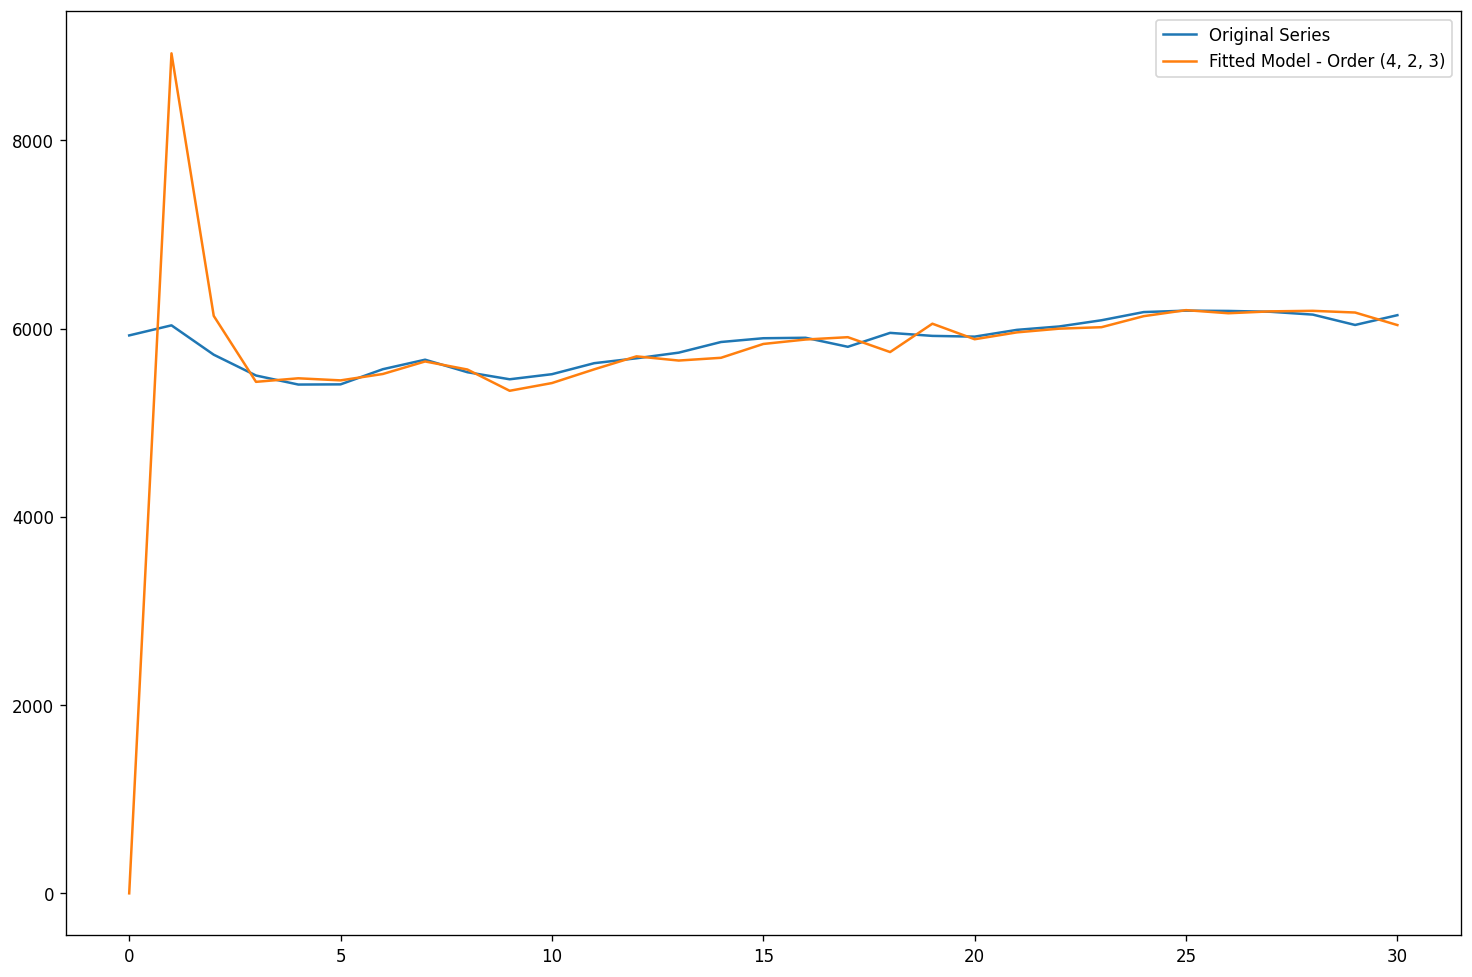

In [44]:
# Plot the original series
plt.plot(series, label='Original Series')

# Plot the fitted models
# plt.plot(model_fit1.fittedvalues, label=f'Fitted Model - Order {order1}')
# plt.plot(model_fit3.fittedvalues, label=f'Fitted Model - Order {order3}')
# plt.plot(model_fit4.fittedvalues, label=f'Fitted Model - Order {order4}')
plt.plot(model_fit5.fittedvalues, label=f'Fitted Model - Order {order5}')

# Add legends
plt.legend()

# Show the plot
plt.show()

In [45]:
#Lets try to incorporate seasonality to see if the results are better
# d = 1 and AR = 1
P=0
D=2
Q=1

model = sm.tsa.SARIMAX(series, order=(Q,D,P),seasonal_order=(Q,D,P,12))
model_fit = model.fit()
print(model_fit.summary())


c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                ADP   No. Observations:                   31
Model:             SARIMAX(1, 2, 0)x(1, 2, 0, 12)   Log Likelihood                 -34.784
Date:                            Tue, 06 Feb 2024   AIC                             75.567
Time:                                    15:20:24   BIC                             74.396
Sample:                                         0   HQIC                            72.423
                                             - 31                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2682      0.429      0.626      0.531      -0.572       1.108
ar.S.L12      -0.9933      0.007   

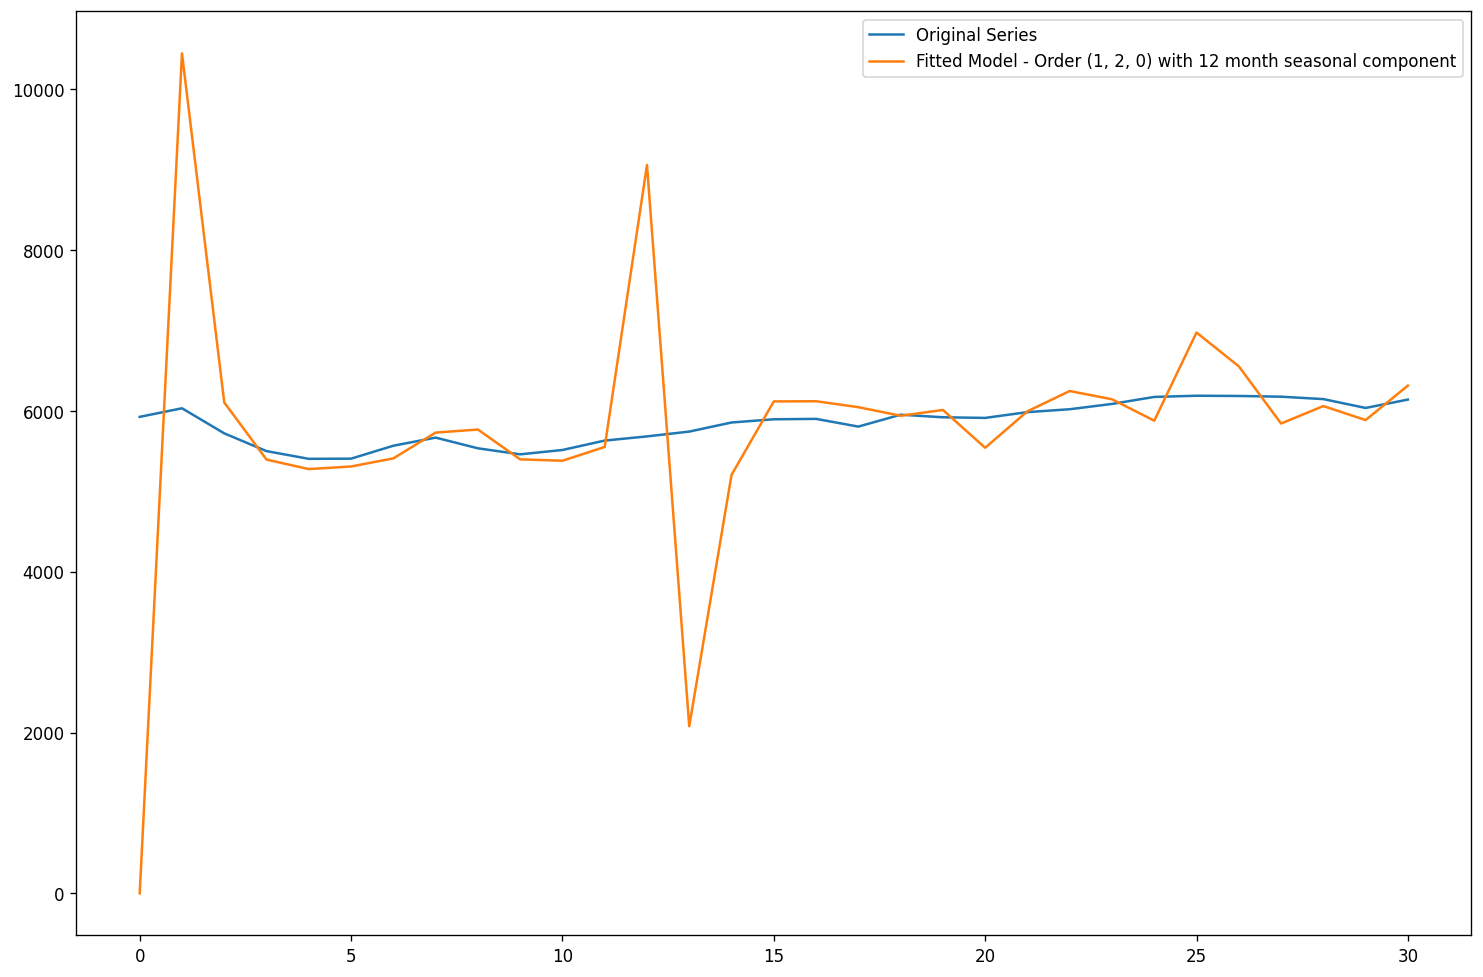

In [46]:
#plot
# Plot the original series
plt.plot(series, label='Original Series')

# Plot the fitted models
plt.plot(model_fit.fittedvalues, label=f'Fitted Model - Order {(Q,D,P)} with 12 month seasonal component')

# Add legends
plt.legend()

# Show the plot
plt.show()

### Now we are going to fit a model on a training set of the data and test it on a small portion of the time series.

Measure the performance using mean square error which is the most commonly used metric that gives a higher penalty to large errors and vice versa.

In [47]:
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# Step 2: Determine stationarity and find differencing degree
d = ndiffs(series, test='adf')
print('Based on ADF test, the optimal coefficient for d is: ',d)
# Step 3: Iterate through ARIMA models to find the optimal one
best_mse = float('inf')
best_order = None

for d in range(3):
    for p in range(5):
        for q in range(5):
            try:
                model = ARIMA(train, order=(p, d, q))
                results = model.fit(method_kwargs={'warn_convergence': False})
                pred = results.get_forecast(steps=len(test))
                mse = mean_squared_error(test, pred.predicted_mean)

                if mse < best_mse:
                    best_mse = mse
                    best_order = (p, d, q)

            except:
                continue
print(best_order, best_mse)

Based on ADF test, the optimal coefficient for d is:  1


c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parame

(0, 1, 1) 3698.654802355


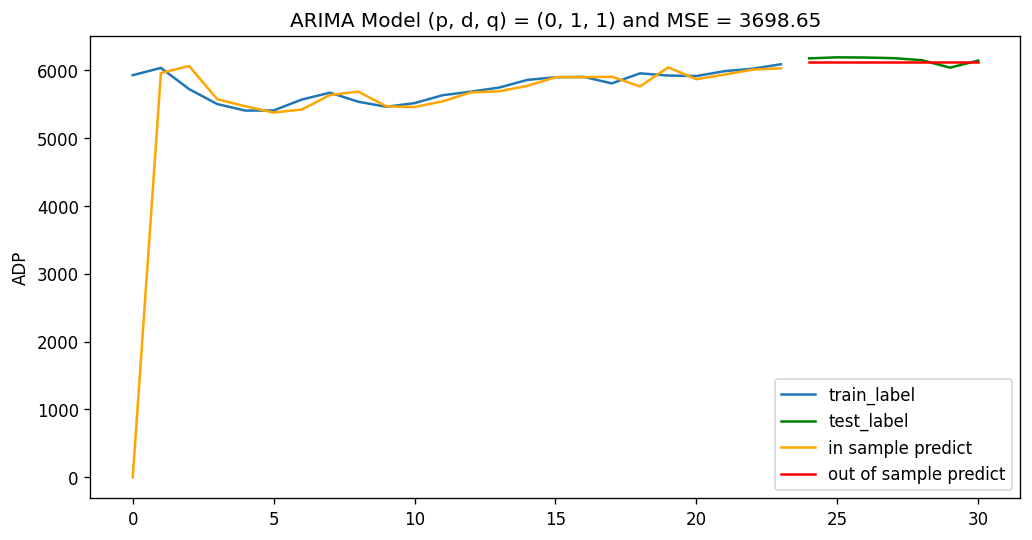

In [48]:
#plot
#fit 
model = ARIMA(train, order=best_order)
results = model.fit(method_kwargs={'warn_convergence': False})
# Perform in-sample predictions
train_predictions = results.predict()
pred = results.get_forecast(steps=len(test))
fc_series = pd.Series(pred.summary_frame()['mean'].values)

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(train.index,train,label='train_label') # train
ax.plot(test.index,test,color='green',label='test_label') # test
ax.plot(train.index,train_predictions,color='orange',label='in sample predict') # in-sample
ax.plot(test.index,fc_series,color='red',label='out of sample predict') # out of sample

plt.xlabel('')
plt.ylabel('ADP')
plt.title(f'ARIMA Model (p, d, q) = {best_order} and MSE = {best_mse.round(2)}')
plt.legend()
plt.show()

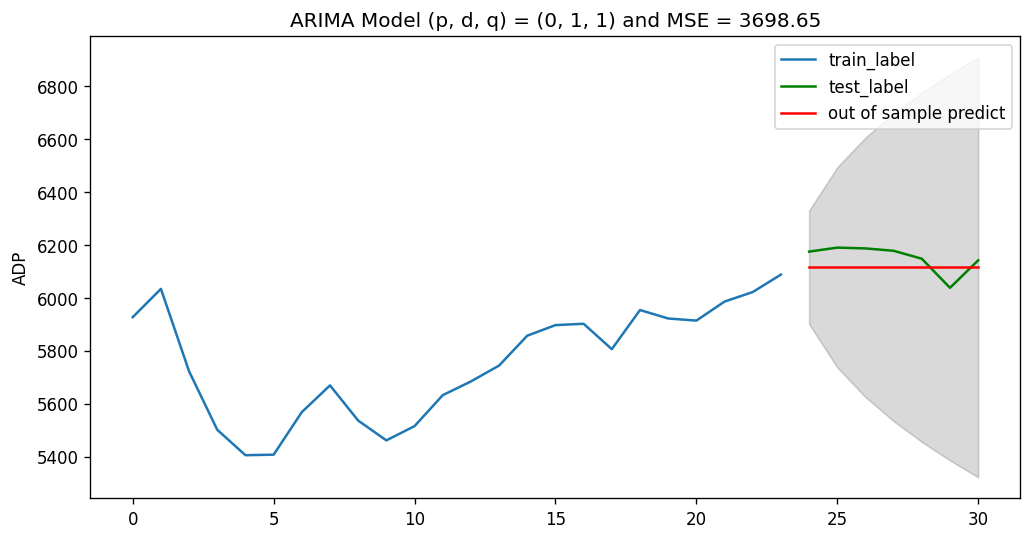

In [49]:
#plot just forecast and CI

fc = pred.summary_frame()
lower_series = pd.Series(fc.mean_ci_lower, index=fc.index)
upper_series = pd.Series(fc.mean_ci_upper, index=fc.index)

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(train.index,train,label='train_label') # train
ax.plot(test.index,test,color='green',label='test_label') # test
# ax.plot(train.index,train_predictions,color='orange',label='in sample predict') # in-sample
ax.plot(test.index,fc_series,color='red',label='out of sample predict') # out of sample
ax.fill_between(fc.index, lower_series, upper_series, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('ADP')
plt.title(f'ARIMA Model (p, d, q) = {best_order} and MSE = {best_mse.round(2)}')
plt.legend()
plt.show()

In [50]:
pred.summary_frame()

ADP,mean,mean_se,mean_ci_lower,mean_ci_upper
24,6115.466281,109.326856,5901.189581,6329.742982
25,6115.466281,193.193000,5736.814959,6494.117603
26,6115.466281,250.389115,5624.712634,6606.219929
27,6115.466281,296.758964,5533.829400,6697.103163
28,6115.466281,336.804181,5455.342217,6775.590346
29,6115.466281,372.569765,5385.242959,6845.689603
30,6115.466281,405.190577,5321.307343,6909.625219


In [51]:
test

24    6175.0
25    6190.0
26    6187.0
27    6178.0
28    6148.0
29    6038.0
30    6142.0
Name: ADP, dtype: float64

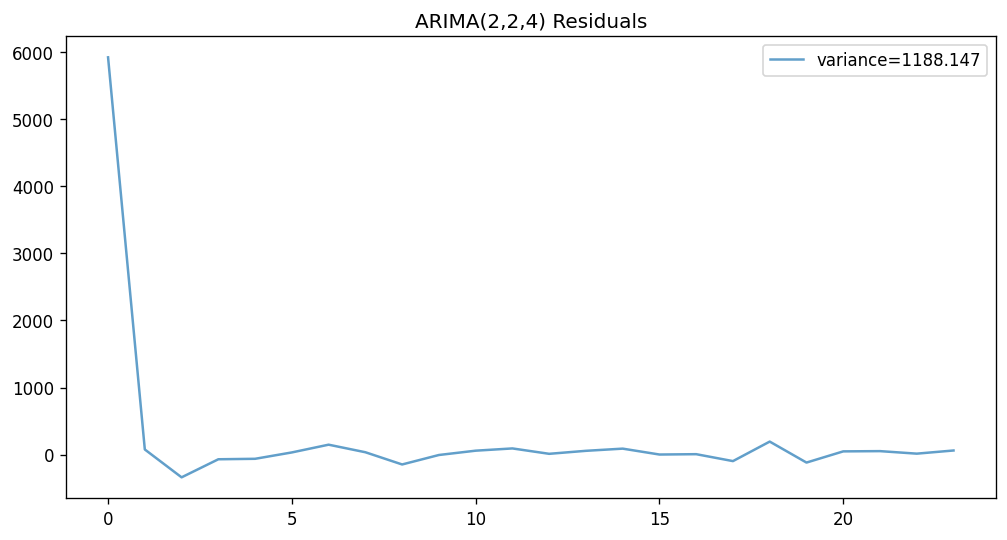

In [52]:
#plot the residuals
plt.plot(results.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(results.resid.values)));
plt.title("ARIMA(2,2,4) Residuals")
plt.legend()


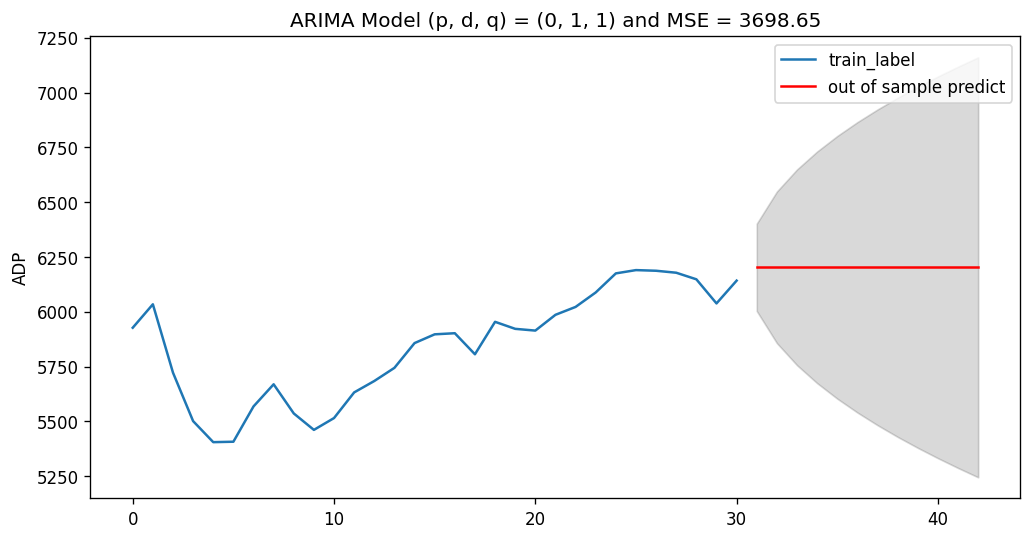

In [53]:
#forecast 12 months out
#plot
#fit 
model = ARIMA(series, order=best_order)
results = model.fit(method_kwargs={'warn_convergence': False})
# Perform in-sample predictions
train_predictions = results.predict()
pred = results.get_forecast(steps=12)
fc_series = pd.Series(pred.summary_frame()['mean'].values)

fc = pred.summary_frame()
lower_series = pd.Series(fc.mean_ci_lower, index=fc.index)
upper_series = pd.Series(fc.mean_ci_upper, index=fc.index)

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(series.index,series,label='train_label') # all data
ax.plot(fc.index,fc_series,color='red',label='out of sample predict') # out of sample
ax.fill_between(fc.index, lower_series, upper_series, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('ADP')
plt.title(f'ARIMA Model (p, d, q) = {best_order} and MSE = {best_mse.round(2)}')
plt.legend()
plt.show()

In [54]:
fc

ADP,mean,mean_se,mean_ci_lower,mean_ci_upper
31,6202.619643,101.733539,6003.225570,6402.013716
32,6202.619643,176.443067,5856.797587,6548.441699
33,6202.619643,227.847753,5756.046254,6649.193033
34,6202.619643,269.623889,5674.166532,6731.072754
35,6202.619643,305.744148,5603.372125,6801.867162
36,6202.619643,338.026518,5540.099842,6865.139444
37,6202.619643,367.483836,5482.364560,6922.874726
38,6202.619643,394.749050,5428.925723,6976.313564
39,6202.619643,420.249039,5378.946662,7026.292625
40,6202.619643,444.287855,5331.831449,7073.407837


### Lets check to see which GLM would be best given our data.

1. Poisson Distribution assumes $E[Y] = Var[Y] = \lambda$

2. Negative Binomial Regression which assumes $Var[Y] = E[Y] + \alpha \cdot E[Y]$

In [55]:
#check mean and variance of dataset
mu = train.mean()
var = train.var()

print(f'The training set has a mean of {mu} and variance of {var}')

The training set has a mean of 5756.375 and variance of 45840.41847826087


Based on the results above, our jail population dataset does not follow a Poisson distribution. Lets try Negative Binomial Regression

In [56]:
#add date related regressors
_30day_pop_tot['Month'] = _30day_pop_tot['Start Date'].dt.month
_30day_pop_tot['Year'] = _30day_pop_tot['Start Date'].dt.year
#make a binary flag for major us holidays: New Years, Fourth of July, Labor Day, Halloween, Thanksgiving, Christmas/Hanukkah/Kwanzaa
_30day_pop_tot['Holiday'] = _30day_pop_tot['Month'].isin([1, 7, 9, 10, 11, 12]).astype(int)
_30day_pop_tot = _30day_pop_tot.rename(columns={'Total Population': 'ADP'})
#add lag term
for i in range(1,13):
    _30day_pop_tot['adp_lag'+str(i)] = _30day_pop_tot['ADP'].shift(i)

#fillnas with zero
_30day_pop_tot = _30day_pop_tot.fillna(0)
_30day_pop_tot.head()

C:\Users\emjoh\AppData\Local\Temp\ipykernel_2596\1003594945.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _30day_pop_tot['Month'] = _30day_pop_tot['Start Date'].dt.month
C:\Users\emjoh\AppData\Local\Temp\ipykernel_2596\1003594945.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _30day_pop_tot['Year'] = _30day_pop_tot['Start Date'].dt.year
C:\Users\emjoh\AppData\Local\Temp\ipykernel_2596\1003594945.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,Start Date,End Date,ADP,Month,Year,Holiday,adp_lag1,adp_lag2,adp_lag3,adp_lag4,adp_lag5,adp_lag6,adp_lag7,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12
0,2021-07-21 00:00:00-04:00,2021-08-19 00:00:00-04:00,5927.0,7,2021,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-08-20 00:00:00-04:00,2021-09-18 00:00:00-04:00,6034.0,8,2021,0,5927.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-09-19 00:00:00-04:00,2021-10-18 00:00:00-04:00,5722.0,9,2021,1,6034.0,5927.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-10-19 00:00:00-04:00,2021-11-17 00:00:00-05:00,5501.0,10,2021,1,5722.0,6034.0,5927.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-11-18 00:00:00-05:00,2021-12-17 00:00:00-05:00,5405.0,11,2021,1,5501.0,5722.0,6034.0,5927.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
#create the training and testing data sets
train_size = int(len(_30day_pop_tot) * 0.8)
# train_size = 28
df_train = _30day_pop_tot.iloc[:train_size]
df_test = _30day_pop_tot.iloc[train_size:]

print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=24
Testing data set length=7


In [58]:
df_train.head()

,Start Date,End Date,ADP,Month,Year,Holiday,adp_lag1,adp_lag2,adp_lag3,adp_lag4,adp_lag5,adp_lag6,adp_lag7,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12
0,2021-07-21 00:00:00-04:00,2021-08-19 00:00:00-04:00,5927.0,7,2021,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-08-20 00:00:00-04:00,2021-09-18 00:00:00-04:00,6034.0,8,2021,0,5927.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-09-19 00:00:00-04:00,2021-10-18 00:00:00-04:00,5722.0,9,2021,1,6034.0,5927.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-10-19 00:00:00-04:00,2021-11-17 00:00:00-05:00,5501.0,10,2021,1,5722.0,6034.0,5927.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-11-18 00:00:00-05:00,2021-12-17 00:00:00-05:00,5405.0,11,2021,1,5501.0,5722.0,6034.0,5927.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
#scale the dataset for all variables to be within the same range of values, 0 to 1.
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
df_train_sc = sc.fit_transform(df_train.drop(columns=['Start Date','End Date']))
df_test_sc = sc.transform(df_test.drop(columns=['Start Date','End Date']))
#convert these arrays to dfs
df_train_sc = pd.DataFrame(data=df_train_sc, columns=df_train.columns.to_list()[2:])
df_test_sc = pd.DataFrame(data=df_test_sc, columns=df_train.columns.to_list()[2:])

In [60]:
type(df_train_sc)

pandas.core.frame.DataFrame

In [61]:
df_train_sc.head()

,ADP,Month,Year,Holiday,adp_lag1,adp_lag2,adp_lag3,adp_lag4,adp_lag5,adp_lag6,adp_lag7,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12
0,0.764275,0.545455,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.920937,0.636364,0.0,0.0,0.982267,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.464129,0.727273,0.0,1.0,1.000000,0.982267,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.140556,0.818182,0.0,1.0,0.948293,1.000000,0.982267,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.909091,0.0,1.0,0.911667,0.948293,1.000000,0.982267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
df_test_sc.head()

,ADP,Month,Year,Holiday,adp_lag1,adp_lag2,adp_lag3,adp_lag4,adp_lag5,adp_lag6,adp_lag7,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12
0,1.127379,0.545455,1.0,1.0,1.008949,0.998011,0.992045,0.980113,0.981439,0.986742,0.962214,0.978124,0.977295,0.970666,0.951939,0.941995
1,1.149341,0.636364,1.0,0.0,1.023368,1.008949,0.998011,0.992045,0.980113,0.981439,0.986742,0.962214,0.978124,0.977295,0.970666,0.951939
2,1.144949,0.727273,1.0,1.0,1.025853,1.023368,1.008949,0.998011,0.992045,0.980113,0.981439,0.986742,0.962214,0.978124,0.977295,0.970666
3,1.131772,0.818182,1.0,1.0,1.025356,1.025853,1.023368,1.008949,0.998011,0.992045,0.980113,0.981439,0.986742,0.962214,0.978124,0.977295
4,1.087848,0.909091,1.0,1.0,1.023865,1.025356,1.025853,1.023368,1.008949,0.998011,0.992045,0.980113,0.981439,0.986742,0.962214,0.978124


In [63]:
from patsy import dmatrices

#Setup the regression expression in patsy notation
#use all regressors for now, we can tune later
expr = """ADP ~ 0 + Month + Year + Holiday + adp_lag1 + adp_lag2 + adp_lag3 + adp_lag4
                + adp_lag5 + adp_lag6 + adp_lag7 + adp_lag8 + adp_lag9 + adp_lag10 + adp_lag11 + adp_lag12"""

#Set up the X and y matrices for the training and testing data sets
y_train, X_train = dmatrices(expr, df_train_sc, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test_sc, return_type='dataframe')


In [64]:
X_train.tail()

,Month,Year,Holiday,adp_lag1,adp_lag2,adp_lag3,adp_lag4,adp_lag5,adp_lag6,adp_lag7,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12
19,0.090909,1.0,0.0,0.986742,0.962214,0.978124,0.977295,0.970666,0.951939,0.941995,0.933378,0.913987,0.905038,0.917468,0.939509
20,0.181818,1.0,0.0,0.981439,0.986742,0.962214,0.978124,0.977295,0.970666,0.951939,0.941995,0.933378,0.913987,0.905038,0.917468
21,0.272727,1.0,0.0,0.980113,0.981439,0.986742,0.962214,0.978124,0.977295,0.970666,0.951939,0.941995,0.933378,0.913987,0.905038
22,0.363636,1.0,0.0,0.992045,0.980113,0.981439,0.986742,0.962214,0.978124,0.977295,0.970666,0.951939,0.941995,0.933378,0.913987
23,0.454545,1.0,0.0,0.998011,0.992045,0.980113,0.981439,0.986742,0.962214,0.978124,0.977295,0.970666,0.951939,0.941995,0.933378


In [65]:
#Using the statsmodels GLM class, train the Poisson regression model on the training data set
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

#print out the fitted rate vector
print(poisson_training_results.mu)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    ADP   No. Observations:                   24
Model:                            GLM   Df Residuals:                        9
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16.245
Date:                Tue, 06 Feb 2024   Deviance:                      0.54460
Time:                        15:20:35   Pearson chi2:                    0.514
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1888
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Month          0.2068      1.605      0.129      0.8

       mean   mean_se  mean_ci_lower  mean_ci_upper
0  0.889120  0.654644       0.210008       3.764313
1  0.931738  0.735528       0.198309       4.377692
2  0.869506  0.694868       0.181565       4.164013
3  0.856508  0.753427       0.152746       4.802763
4  0.864194  0.844972       0.127158       5.873267
5  0.894033  0.982585       0.103715       7.706631
6  1.354512  1.865898       0.091037      20.153427


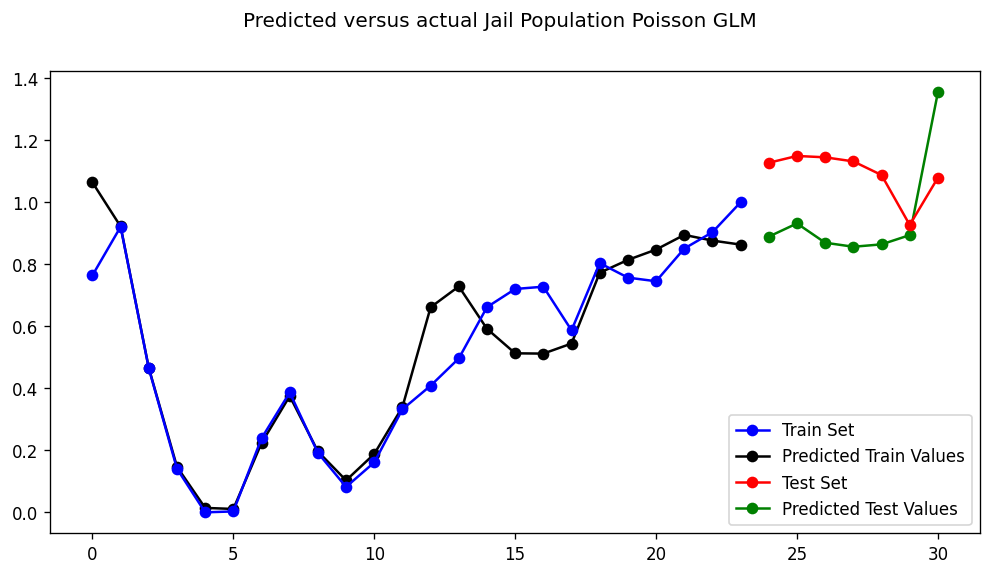

In [66]:
#make some predictions using our trained NB2 model
poisson_predictions = poisson_training_results.get_prediction(X_test)

#print out the predictions
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

#plot the predicted counts versus the actual counts for the test data
IS_predicted_counts = poisson_training_results.predict(X_train)
OS_predicted_counts = predictions_summary_frame['mean']
actual_counts = y_test['ADP']
fig = plt.figure()
fig.suptitle('Predicted versus actual Jail Population Poisson GLM')
predicted_train, = plt.plot(X_train.index, IS_predicted_counts, 'ko-', label='Predicted Train Values')
train_set, = plt.plot(X_train.index, y_train['ADP'], 'bo-', label='Train Set')
predicted_test, = plt.plot(range(len(X_train),len(X_train)+len(X_test)), OS_predicted_counts, 'go-', label='Predicted Test Values')
test_set, = plt.plot(range(len(X_train),len(X_train)+len(X_test)), actual_counts, 'ro-', label='Test Set')
plt.legend(handles=[train_set,predicted_train, test_set, predicted_test])
plt.show()

In [67]:
#remove year from the equation
expr = """ADP ~ 0 + Month + Holiday + adp_lag1 + adp_lag2 + adp_lag3 + adp_lag4
                + adp_lag5 + adp_lag6 + adp_lag7 + adp_lag8 + adp_lag9 + adp_lag10 + adp_lag11 + adp_lag12"""

#Set up the X and y matrices for the training and testing data sets
y_train, X_train = dmatrices(expr, df_train_sc, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test_sc, return_type='dataframe')

#Using the statsmodels GLM class, train the Poisson regression model on the training data set
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

#print out the fitted rate vector
print(poisson_training_results.mu)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    ADP   No. Observations:                   24
Model:                            GLM   Df Residuals:                       10
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16.386
Date:                Tue, 06 Feb 2024   Deviance:                      0.82749
Time:                        15:20:36   Pearson chi2:                    0.745
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1792
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Month         -0.3528      1.259     -0.280      0.7

       mean   mean_se  mean_ci_lower  mean_ci_upper
0  0.666735  0.347773       0.239862       1.853299
1  0.694755  0.409529       0.218818       2.205867
2  0.604600  0.289119       0.236823       1.543518
3  0.569675  0.291001       0.209323       1.550378
4  0.548890  0.311604       0.180409       1.669981
5  0.535937  0.340946       0.154030       1.864754
6  0.800551  0.769122       0.121788       5.262273


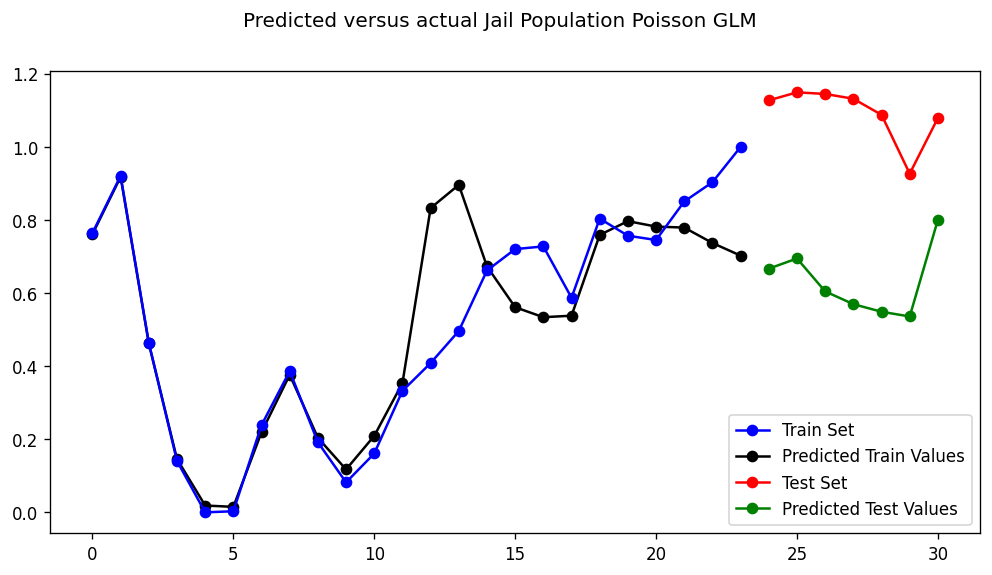

In [68]:
#make some predictions using our trained NB2 model
poisson_predictions = poisson_training_results.get_prediction(X_test)

#print out the predictions
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

#plot the predicted counts versus the actual counts for the test data
IS_predicted_counts = poisson_training_results.predict(X_train)
OS_predicted_counts = predictions_summary_frame['mean']
actual_counts = y_test['ADP']
fig = plt.figure()
fig.suptitle('Predicted versus actual Jail Population Poisson GLM')
predicted_train, = plt.plot(X_train.index, IS_predicted_counts, 'ko-', label='Predicted Train Values')
train_set, = plt.plot(X_train.index, y_train['ADP'], 'bo-', label='Train Set')
predicted_test, = plt.plot(range(len(X_train),len(X_train)+len(X_test)), OS_predicted_counts, 'go-', label='Predicted Test Values')
test_set, = plt.plot(range(len(X_train),len(X_train)+len(X_test)), actual_counts, 'ro-', label='Test Set')
plt.legend(handles=[train_set,predicted_train, test_set, predicted_test])
plt.show()

In [69]:
#Add the λ vector as a new column called 'BB_LAMBDA' to the Data Frame of the training data set
df_train['ADP_LAMBDA'] = poisson_training_results.mu

#add a derived column called 'AUX_OLS_DEP' to the pandas Data Frame. This new column will store the values of the dependent variable of the OLS regression
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['ADP'] - x['ADP_LAMBDA'])**2 - x['ADP_LAMBDA']) / x['ADP_LAMBDA'], axis=1)

#use patsy to form the model specification for the OLSR
ols_expr = """AUX_OLS_DEP ~ ADP_LAMBDA - 1"""

#Configure and fit the OLSR model
aux_olsr_results = smf.ols(ols_expr, df_train).fit()

C:\Users\emjoh\AppData\Local\Temp\ipykernel_2596\1067696103.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ADP_LAMBDA'] = poisson_training_results.mu
C:\Users\emjoh\AppData\Local\Temp\ipykernel_2596\1067696103.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['ADP'] - x['ADP_LAMBDA'])**2 - x['ADP_LAMBDA']) / x['ADP_LAMBDA'], axis=1)


In [70]:
#Print the regression params
print(aux_olsr_results.params)

ADP_LAMBDA    9.504698e+07
dtype: float64


If the value of $\alpha$ (ADP_LAMBDA) is statistically not significant, then the Negative Binomial regression model cannot do a better job of fitting the training data set than a Poisson regression model. To check whether or not $\alpha$ is statistically significant or not, we will extract the t-value from the OLS result and use a [t-value calculator](https://goodcalculators.com/student-t-value-calculator/) to determine with `degrees of freedom = len(df_train) - 1 = 23` what the critical t-value is.

t-value at a 95% confidence level (right-tailed) & df = 23: 1.714

t-value at a 95% confidence level (two-tailed) & df = 23: +/- 2.068

In [71]:
aux_olsr_results.tvalues

ADP_LAMBDA    0.521462
dtype: float64

The t-statistic of $\alpha$ is below the t-value found with 95% confidence and df = 23. Therefore it is not statistically significant and the NB GLM with this alpha value is no better than the Poisson Distribution.

In [72]:
#train the NB2 model on the training data set
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

#print the training summary
print(nb2_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    ADP   No. Observations:                   24
Model:                            GLM   Df Residuals:                       10
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -399.89
Date:                Tue, 06 Feb 2024   Deviance:                   3.5085e-08
Time:                        15:20:36   Pearson chi2:                 2.17e-08
No. Iterations:                    18   Pseudo R-squ. (CS):          2.137e-08
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Month         -0.4466   1.05e+04  -4.27e-05      1.0

In [73]:
#make some predictions using our trained NB2 model
nb2_predictions = nb2_training_results.get_prediction(X_test)

#print out the predictions
predictions_summary_frame = nb2_predictions.summary_frame()
print(predictions_summary_frame)

       mean      mean_se  mean_ci_lower  mean_ci_upper
0  0.848031  3458.946415            0.0            inf
1  0.618230  3046.876362            0.0            inf
2  0.669728  2508.515474            0.0            inf
3  0.573383  2245.537137            0.0            inf
4  0.522160  2254.339700            0.0            inf
5  0.599266  2932.103594            0.0            inf
6  1.032812  8377.112741            0.0            inf


c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\genmod\families\links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)


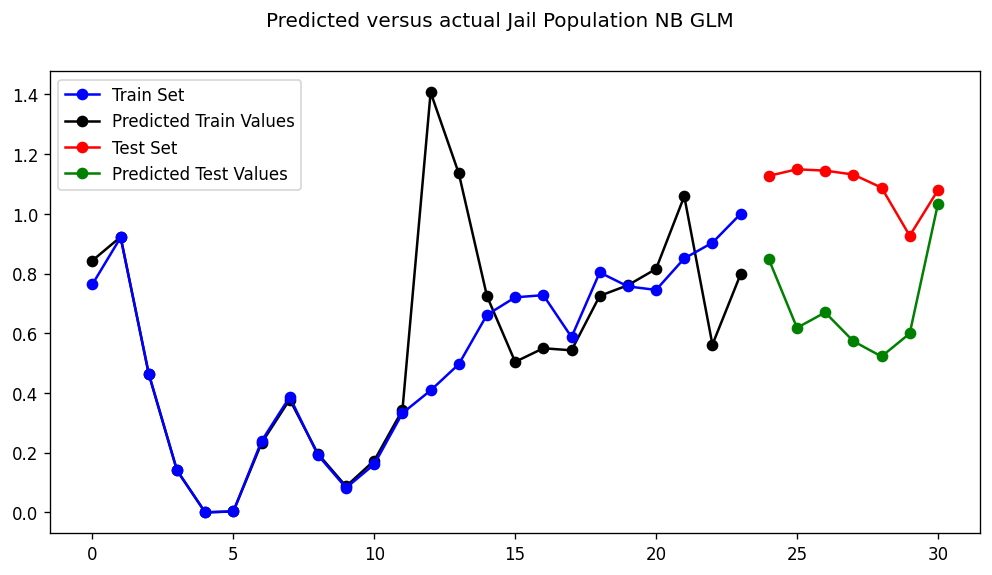

In [74]:
#plot the predicted counts versus the actual counts for the test data
IS_predicted_counts = nb2_training_results.predict(X_train)
OS_predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['ADP']
fig = plt.figure()
fig.suptitle('Predicted versus actual Jail Population NB GLM')
predicted_train, = plt.plot(X_train.index, IS_predicted_counts, 'ko-', label='Predicted Train Values')
train_set, = plt.plot(X_train.index, y_train['ADP'], 'bo-', label='Train Set')
predicted_test, = plt.plot(range(len(X_train),len(X_train)+len(X_test)), OS_predicted_counts, 'go-', label='Predicted Test Values')
test_set, = plt.plot(range(len(X_train),len(X_train)+len(X_test)), actual_counts, 'ro-', label='Test Set')
plt.legend(handles=[train_set,predicted_train, test_set, predicted_test])
plt.show()

## Linear Regression

This method is similar to that above, in that we will use the same scaled regressors. However, we won't specify a family of equations for the linear model.

In [75]:
#df_Train_Sc and df_test_sc are the two scaled dataframe with all the regressors and target variable
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

data = _30day_pop_tot.copy()
#train test split
train_size = int(len(data) * 0.8)
df_train = data.iloc[:train_size]
df_test = data.iloc[train_size:]

#scale the dataset for all variables to be within the same range of values, 0 to 1.
sc = MinMaxScaler()
df_train_sc = sc.fit_transform(df_train.drop(columns=['Start Date','End Date']))
df_test_sc = sc.transform(df_test.drop(columns=['Start Date','End Date']))
#convert these arrays to dfs
df_train_sc = pd.DataFrame(data=df_train_sc, columns=df_train.columns.to_list()[2:])
df_test_sc = pd.DataFrame(data=df_test_sc, columns=df_train.columns.to_list()[2:])
#add constant to both train and test datasets
df_train_sc = sm.add_constant(df_train_sc,prepend=False, has_constant='add')
df_test_sc = sm.add_constant(df_test_sc,prepend=False, has_constant='add')

X_train, y_train = df_train_sc.drop(columns=['ADP']), df_train_sc['ADP']
X_test, y_test = df_test_sc.drop(columns=['ADP']),df_test_sc['ADP']

X_train.head()

,Month,Year,Holiday,adp_lag1,adp_lag2,adp_lag3,adp_lag4,adp_lag5,adp_lag6,adp_lag7,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12,const
0,0.545455,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.636364,0.0,0.0,0.982267,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.727273,0.0,1.0,1.000000,0.982267,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.818182,0.0,1.0,0.948293,1.000000,0.982267,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.909091,0.0,1.0,0.911667,0.948293,1.000000,0.982267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [76]:
print(df_train_sc.const.unique())
print(df_test_sc.const.unique())

[1.]
[1.]


In [77]:
#fit linear regression model
model = sm.OLS(y_train,X_train).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     22.82
Date:                Tue, 06 Feb 2024   Prob (F-statistic):           6.39e-05
Time:                        15:20:36   Log-Likelihood:                 39.650
No. Observations:                  24   AIC:                            -47.30
Df Residuals:                       8   BIC:                            -28.45
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Month          0.6364      0.149      4.268      0.0

In [78]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Print the predicted values
print("Predicted values:\n", y_pred)

Predicted values:
 0    1.105559
1    1.070133
2    1.202306
3    1.249829
4    1.305436
5    1.362926
6    1.425367
dtype: float64


In [79]:
# Now, you can compare the predicted values (y_pred) with the actual values (y_test)
# For example, you can calculate the R-squared value to measure the goodness of fit

from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("\nR-squared:", r2)



R-squared: -9.479280417565949


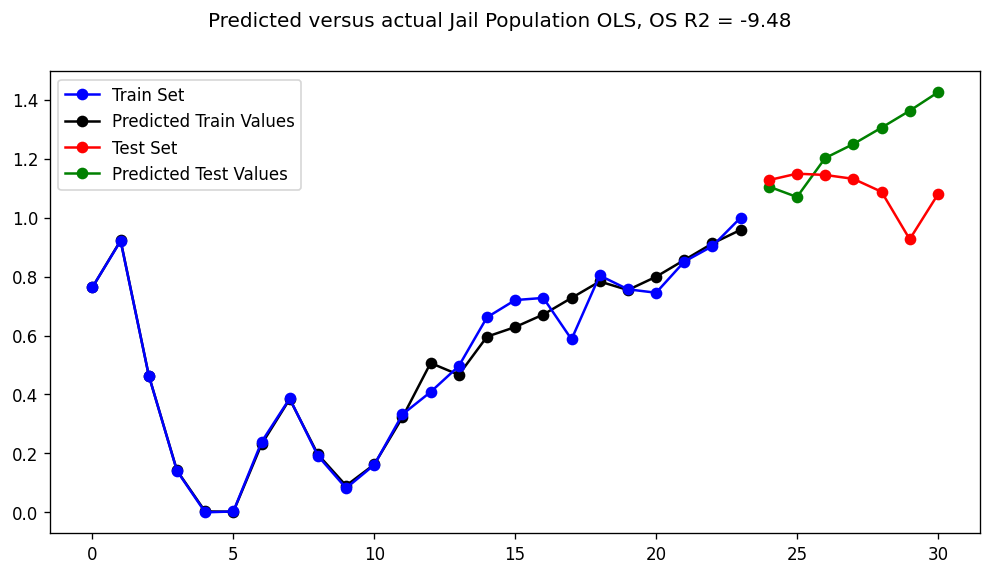

In [80]:
#plot
#plot the predicted counts versus the actual counts for the test data
IS_predicted_counts = model.predict(X_train)
OS_predicted_counts = y_pred
actual_counts = y_test
fig = plt.figure()
fig.suptitle(f'Predicted versus actual Jail Population OLS, OS R2 = {r2.round(2)}')
predicted_train, = plt.plot(X_train.index, IS_predicted_counts, 'ko-', label='Predicted Train Values')
train_set, = plt.plot(X_train.index, y_train, 'bo-', label='Train Set')
predicted_test, = plt.plot(range(len(X_train),len(X_train)+len(X_test)), OS_predicted_counts, 'go-', label='Predicted Test Values')
test_set, = plt.plot(range(len(X_train),len(X_train)+len(X_test)), actual_counts, 'ro-', label='Test Set')
plt.legend(handles=[train_set,predicted_train, test_set, predicted_test])
plt.show()

In [81]:
#fit the model to the entire dataset and forecast
# Scale the entire dataset
sc = MinMaxScaler()
data_sc = sc.fit_transform(data.drop(columns=['Start Date', 'End Date']))

# Convert the array to a DataFrame
data_sc = pd.DataFrame(data=data_sc, columns=data.columns.to_list()[2:])

# Add constant to the dataset
data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

# Split the dataset into features (X) and target (y)
X = data_sc.drop(columns=['ADP'])
y = data_sc['ADP']

# Fit the linear regression model on the entire dataset
model = sm.OLS(y, X).fit()

# Make predictions on the test set
IS_pred = model.predict(X)
IS_mse = mean_squared_error(y,IS_pred)

print(IS_mse)
print(model.summary())

0.004999003270708427
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     19.06
Date:                Tue, 06 Feb 2024   Prob (F-statistic):           4.23e-07
Time:                        15:20:36   Log-Likelihood:                 38.140
No. Observations:                  31   AIC:                            -44.28
Df Residuals:                      15   BIC:                            -21.34
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Month          0.4057      0.10

In [82]:
data.head()

,Start Date,End Date,ADP,Month,Year,Holiday,adp_lag1,adp_lag2,adp_lag3,adp_lag4,adp_lag5,adp_lag6,adp_lag7,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12
0,2021-07-21 00:00:00-04:00,2021-08-19 00:00:00-04:00,5927.0,7,2021,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-08-20 00:00:00-04:00,2021-09-18 00:00:00-04:00,6034.0,8,2021,0,5927.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-09-19 00:00:00-04:00,2021-10-18 00:00:00-04:00,5722.0,9,2021,1,6034.0,5927.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-10-19 00:00:00-04:00,2021-11-17 00:00:00-05:00,5501.0,10,2021,1,5722.0,6034.0,5927.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-11-18 00:00:00-05:00,2021-12-17 00:00:00-05:00,5405.0,11,2021,1,5501.0,5722.0,6034.0,5927.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
from datetime import timedelta

# Forecast the next 12 months
#last time stamp from data
last_start_date = data['Start Date'].iloc[-1]

forecast_start_dates = pd.Series()
for i in range(2, 15):
    forecast_start_dates.at[i-2] = last_start_date + timedelta(days=30 * i)
# Create a DataFrame for the next 12 months with the same structure as your dataset
forecast_data = pd.DataFrame(columns = data.columns.to_list()[2:])
forecast_data['ADP'] = np.zeros(12) #placeholder for the minmaxscaler

# Fill in other features like Month, Year, and Holiday (adjust as needed)
forecast_data['Month'] = forecast_start_dates.dt.month # Set the month for forecasting
forecast_data['Year'] = forecast_start_dates.dt.year # Set the year for forecasting
forecast_data['Holiday'] = forecast_data['Month'].isin([1, 7, 9, 10, 11, 12]).astype(int) # Set the holiday flag for forecasting

# Fill in the values for lag terms using the actual values from the dataset
# Since the lags are dependent on the ADP IV, we should predict 1 time stamp ahead 12 independent times
# so we can use the previously predicted ADP value in the lag calculation

#since we have all the lag data for the first prediction, we will do this calculation seperately
forecast_data.iloc[0,4:] = data['ADP'].shift(0).iloc[-12:][::-1].reset_index(drop = True)
# Reshape the one-dimensional array before scaling
forecast_data_scaled = sc.transform(forecast_data.iloc[0].values.reshape(1, -1))

# Convert the scaled array back to a DataFrame
forecast_data_scaled = pd.DataFrame(columns=forecast_data.columns)
# Add the constant to the DataFrame
forecast_data_scaled['const'] = 1
forecast_data_scaled.iloc[0,:-1] = forecast_data_scaled
# Make predictions using the trained model
forecast_predictions = model.predict(forecast_data_scaled.iloc[0].drop(columns = ['ADP']))

#assaign ADP value in the forecast df
forecast_data_scaled.iloc[0,0] = forecast_predictions
forecast_data_scaled

c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


IndexError: iloc cannot enlarge its target object

In [ ]:
data['ADP'].shift(0).iloc[-11:][::-1].reset_index(drop = True)

0     6017.0
1     6129.0
2     6163.0
3     6182.0
4     6194.0
5     6188.0
6     6130.0
7     6035.0
8     6016.0
9     5930.0
10    5924.0
Name: ADP, dtype: float64

In [ ]:
#now that we have the first prediction, lets automate the procedure for the next 11
for i in range(1,12):
    lag_num = 12 - i
    #take the previously predicted value as adp_lag1 and the previous row's adp_1 - adp_11 as regressors
    forecast_data_scaled.iloc[i,0] = 0
    # Add the constant to the DataFrame
    forecast_data_scaled.iloc[i,-1] = 1
    #add the last predicted adp as adp_1 for this row
    forecast_data_scaled.iloc[i,4] = forecast_data_scaled.iloc[i-1,'ADP']
    #shift the lags
    forecast_data_scaled.iloc[i,5:13] = forecast_data_scaled.iloc[i-1,4:12]
    # Make predictions using the trained model
    forecast_predictions = model.predict(forecast_data_scaled.iloc[i].drop(columns = ['ADP']))

    #assaign ADP value in the forecast df
    forecast_data_scaled.iloc[i,0] = forecast_predictions

IndexError: iloc cannot enlarge its target object

In [ ]:
forecast_data

,ADP,Month,Year,Holiday,adp_lag1,adp_lag2,adp_lag3,adp_lag4,adp_lag5,adp_lag6,adp_lag7,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12
0,0.0,2,2024,0,6017.0,6129.0,6163.0,6182.0,6194.0,6188.0,6130.0,6035.0,6016.0,5930.0,5924.0,5947.0
1,0.0,3,2024,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,4,2024,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,5,2024,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,6,2024,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.0,7,2024,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.0,8,2024,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.0,9,2024,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0,10,2024,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.0,11,2024,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Scale the forecast data
forecast_data_sc = sc.transform(forecast_data)

# Add constant to the forecast data
forecast_data_sc = sm.add_constant(forecast_data_sc, prepend=False, has_constant='add')

# Make predictions for the next 12 months
y_forecast = model.predict(forecast_data_sc)

# Print or use y_forecast as needed
print(y_forecast)


This shows the the OLS regression is actually pretty good at measuring the IS data points, but very bad at predicting values it has never seen. This indicates some level of overfitting in the model. We can try to do some feature engineering to increase the OS accuracy.

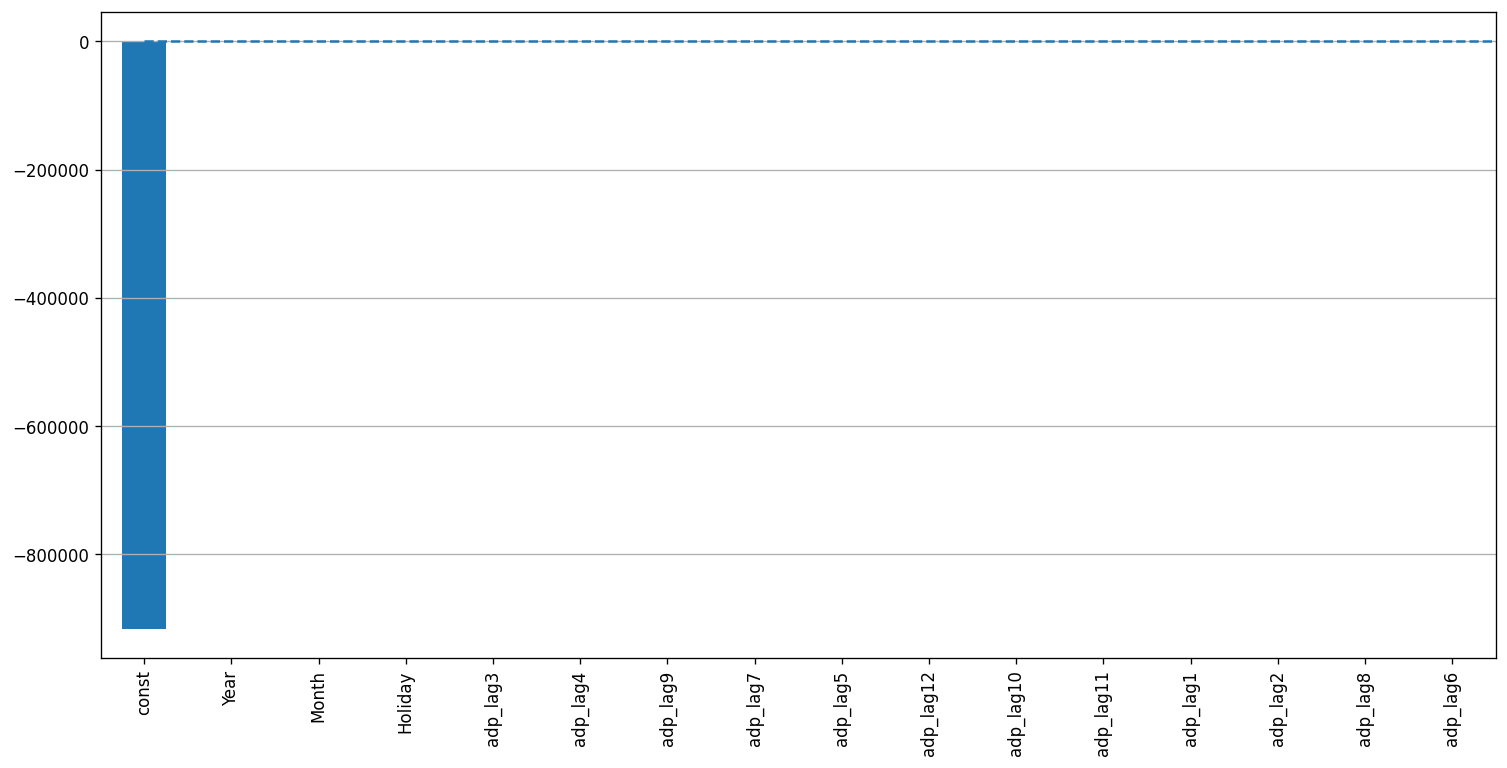

In [ ]:
#print the coefficients of each regression
coefs = pd.DataFrame(model.params.values, X_train.columns)
coefs.columns = ["coef"]
coefs["abs"] = coefs.coef.apply(np.abs)
coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

plt.figure(figsize=(15, 7))
coefs.coef.plot(kind='bar')
plt.grid(True, axis='y')
plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

The constant might be causing some overfitting in the dataframe. Lets remove this regressor and see how the model performs.

In [ ]:
#fit linear regression model
model2 = sm.OLS(y_train,X_train.drop(columns = ['const'])).fit()

#view model summary
print(model2.summary())

                                 OLS Regression Results                                
Dep. Variable:                    ADP   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                              2560.
Date:                Tue, 16 Jan 2024   Prob (F-statistic):                    1.88e-14
Time:                        12:06:50   Log-Likelihood:                         -141.52
No. Observations:                  24   AIC:                                      313.0
Df Residuals:                       9   BIC:                                      330.7
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

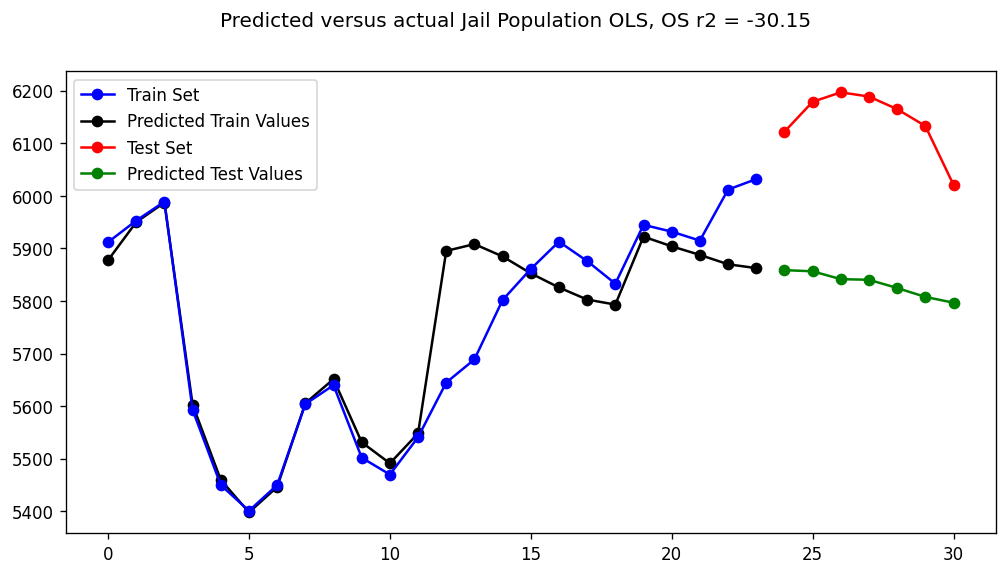

In [ ]:
#plot the predicted counts versus the actual counts for the test data
IS_predicted_counts = model2.predict(X_train.drop(columns = ['const']))
OS_predicted_counts = model2.predict(X_test.drop(columns = ['const']))
OS_r2 = r2_score(y_test, OS_predicted_counts)
actual_counts = y_test
fig = plt.figure()
fig.suptitle(f'Predicted versus actual Jail Population OLS, OS r2 = {OS_r2.round(2)}')
predicted_train, = plt.plot(X_train.index, IS_predicted_counts, 'ko-', label='Predicted Train Values')
train_set, = plt.plot(X_train.index, y_train, 'bo-', label='Train Set')
predicted_test, = plt.plot(range(len(X_train),len(X_train)+len(X_test)), OS_predicted_counts, 'go-', label='Predicted Test Values')
test_set, = plt.plot(range(len(X_train),len(X_train)+len(X_test)), actual_counts, 'ro-', label='Test Set')
plt.legend(handles=[train_set,predicted_train, test_set, predicted_test])
plt.show()

It seems like OLS with the following regressors is still a bad option for prediction unseen data points. I think we would need some more information other than lags to help increase the out of sample accuracy. We could potentially include min/max daily population, variance of ADP as regressors. 

In [ ]:
#aggregate to 30 day intervals
#set data type
adp_df['snapshot_date'] = pd.to_datetime(adp_df['snapshot_date'])
#get latest snapshot date
max_date = adp_df['snapshot_date'].max()
#aggregate to 30 day periods
interval_data = adp_df.resample('30D', on='snapshot_date',origin = max_date,closed='right',label = 'right').mean().round().fillna(0).reset_index()
interval_data = interval_data.rename(columns = {'snapshot_date':'End Date','Total Population':'ADP'})
interval_data['Start Date'] = interval_data['End Date'] - pd.to_timedelta(29, unit='D')

#display just date of the start/end date columns localize to specific timezone or altar will assume UTC in graph
interval_data['Start Date'] = interval_data['Start Date'].dt.tz_localize('America/New_York')
interval_data['End Date'] = interval_data['End Date'].dt.tz_localize('America/New_York')
interval_data = interval_data[['Start Date', 'End Date', 'ADP']]
interval_data.head()

,Start Date,End Date,ADP
0,2021-06-30 00:00:00-04:00,2021-07-29 00:00:00-04:00,5912.0
1,2021-07-30 00:00:00-04:00,2021-08-28 00:00:00-04:00,5953.0
2,2021-08-29 00:00:00-04:00,2021-09-27 00:00:00-04:00,5989.0
3,2021-09-28 00:00:00-04:00,2021-10-27 00:00:00-04:00,5593.0
4,2021-10-28 00:00:00-04:00,2021-11-26 00:00:00-05:00,5450.0


In [ ]:
#add date related regressors
interval_data['Month'] = interval_data['Start Date'].dt.month
interval_data['Year'] = interval_data['Start Date'].dt.year
#make a binary flag for major us holidays: New Years, Fourth of July, Labor Day, Halloween, Thanksgiving, Christmas/Hanukkah/Kwanzaa
interval_data['Holiday'] = interval_data['Month'].isin([1, 7, 9, 10, 11, 12]).astype(int)
interval_data = interval_data.rename(columns={'Total Population': 'ADP'})
#add lag term
for i in range(1,13):
    interval_data['adp_lag'+str(i)] = interval_data['ADP'].shift(i)

#fillnas with zero
interval_data = interval_data.fillna(0)
interval_data.head()

,Start Date,End Date,ADP,Month,Year,Holiday,adp_lag1,adp_lag2,adp_lag3,adp_lag4,adp_lag5,adp_lag6,adp_lag7,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12
0,2021-06-30 00:00:00-04:00,2021-07-29 00:00:00-04:00,5912.0,6,2021,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-07-30 00:00:00-04:00,2021-08-28 00:00:00-04:00,5953.0,7,2021,1,5912.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-08-29 00:00:00-04:00,2021-09-27 00:00:00-04:00,5989.0,8,2021,0,5953.0,5912.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-09-28 00:00:00-04:00,2021-10-27 00:00:00-04:00,5593.0,9,2021,1,5989.0,5953.0,5912.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-10-28 00:00:00-04:00,2021-11-26 00:00:00-05:00,5450.0,10,2021,1,5593.0,5989.0,5953.0,5912.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#create the training and testing data sets
train_size = int(len(interval_data) * 0.8)
df_train = interval_data.iloc[:train_size]
df_test = interval_data.iloc[train_size:]

print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

#scale the dataset for all variables to be within the same range of values, 0 to 1.
sc = MinMaxScaler()
df_train_sc = sc.fit_transform(df_train.drop(columns=['Start Date','End Date']))
df_test_sc = sc.transform(df_test.drop(columns=['Start Date','End Date']))
#convert these arrays to dfs
df_train_sc = pd.DataFrame(data=df_train_sc, columns=df_train.columns.to_list()[2:])
df_test_sc = pd.DataFrame(data=df_test_sc, columns=df_train.columns.to_list()[2:])

Training data set length=24
Testing data set length=7


In [ ]:
df_train_sc.head()

,ADP,Month,Year,Holiday,adp_lag1,adp_lag2,adp_lag3,adp_lag4,adp_lag5,adp_lag6,adp_lag7,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12
0,0.809826,0.454545,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.874802,0.545455,0.0,1.0,0.983367,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.931854,0.636364,0.0,0.0,0.990186,0.987143,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.304279,0.727273,0.0,1.0,0.996174,0.993989,0.987143,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.077655,0.818182,0.0,1.0,0.930306,1.000000,0.993989,0.987143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_test_sc.head()

,ADP,Month,Year,Holiday,adp_lag1,adp_lag2,adp_lag3,adp_lag4,adp_lag5,adp_lag6,adp_lag7,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12
0,1.142631,0.454545,1.0,0.0,1.003327,1.003840,0.987644,0.990483,0.992653,0.973952,0.981132,0.987310,0.978627,0.968776,0.949908,0.942561
1,1.232964,0.545455,1.0,1.0,1.018297,1.007180,1.003840,0.987644,0.990483,0.992653,0.973952,0.981132,0.987310,0.978627,0.968776,0.949908
2,1.261490,0.636364,1.0,0.0,1.027778,1.022207,1.007180,1.003840,0.987644,0.990483,0.992653,0.973952,0.981132,0.987310,0.978627,0.968776
3,1.248811,0.727273,1.0,1.0,1.030772,1.031725,1.022207,1.007180,1.003840,0.987644,0.990483,0.992653,0.973952,0.981132,0.987310,0.978627
4,1.210777,0.818182,1.0,1.0,1.029441,1.034730,1.031725,1.022207,1.007180,1.003840,0.987644,0.990483,0.992653,0.973952,0.981132,0.987310


In [ ]:
X_train, y_train = df_train_sc.drop(columns=['ADP']), df_train_sc['ADP']
X_test, y_test = df_test_sc.drop(columns=['ADP']),df_test_sc['ADP']

In [ ]:
#fit linear regression model
model2 = sm.OLS(y_train,X_train).fit()

#view model summary
print(model2.summary())

                                 OLS Regression Results                                
Dep. Variable:                    ADP   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              27.27
Date:                Tue, 16 Jan 2024   Prob (F-statistic):                    1.15e-05
Time:                        12:06:50   Log-Likelihood:                          22.793
No. Observations:                  24   AIC:                                     -15.59
Df Residuals:                       9   BIC:                                      2.085
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

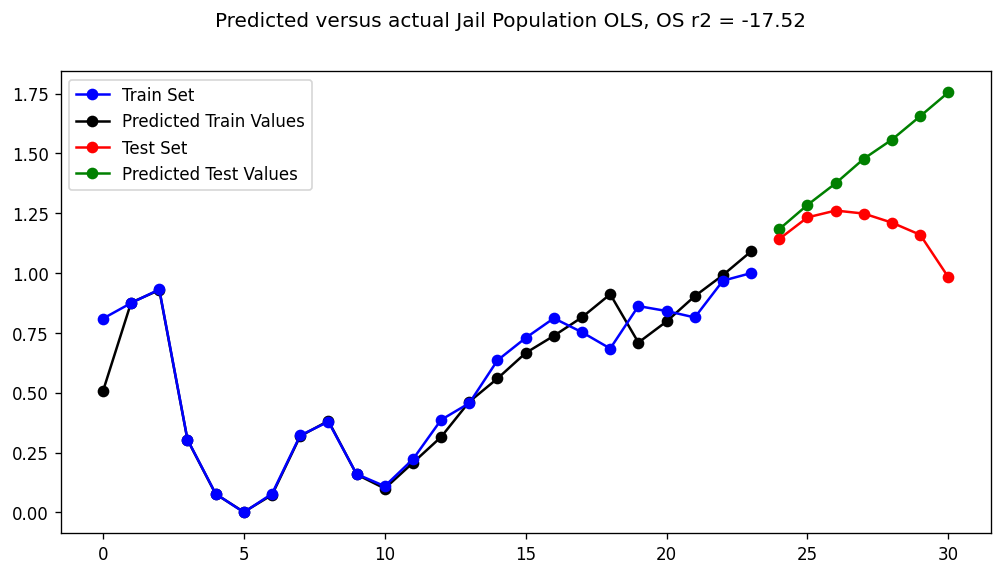

In [ ]:
#plot the predicted counts versus the actual counts for the test data
IS_predicted_counts = model2.predict(X_train)
OS_predicted_counts = model2.predict(X_test)
OS_r2 = r2_score(y_test, OS_predicted_counts)
actual_counts = y_test
fig = plt.figure()
fig.suptitle(f'Predicted versus actual Jail Population OLS, OS r2 = {OS_r2.round(2)}')
predicted_train, = plt.plot(X_train.index, IS_predicted_counts, 'ko-', label='Predicted Train Values')
train_set, = plt.plot(X_train.index, y_train, 'bo-', label='Train Set')
predicted_test, = plt.plot(range(len(X_train),len(X_train)+len(X_test)), OS_predicted_counts, 'go-', label='Predicted Test Values')
test_set, = plt.plot(range(len(X_train),len(X_train)+len(X_test)), actual_counts, 'ro-', label='Test Set')
plt.legend(handles=[train_set,predicted_train, test_set, predicted_test])
plt.show()

In [ ]:
#create the training and testing data sets
train_size = int(len(interval_data) * 0.8)
X, y = interval_data.drop(columns=['Start Date','End Date','ADP']), interval_data['ADP']
X = sm.add_constant(X)

#create the training and testing data sets
train_size = int(len(interval_data) * 0.8)
X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]
X_test, y_test = X.iloc[train_size:], y.iloc[train_size:]
print(X_train.shape, y_train.shape)

model = sm.OLS(y_train, X_train).fit()

#view model summary
print(model.summary())

(24, 16) (24,)
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     24.03
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           5.25e-05
Time:                        12:06:50   Log-Likelihood:                -115.67
No. Observations:                  24   AIC:                             263.3
Df Residuals:                       8   BIC:                             282.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.163e+05   1.17e+05     

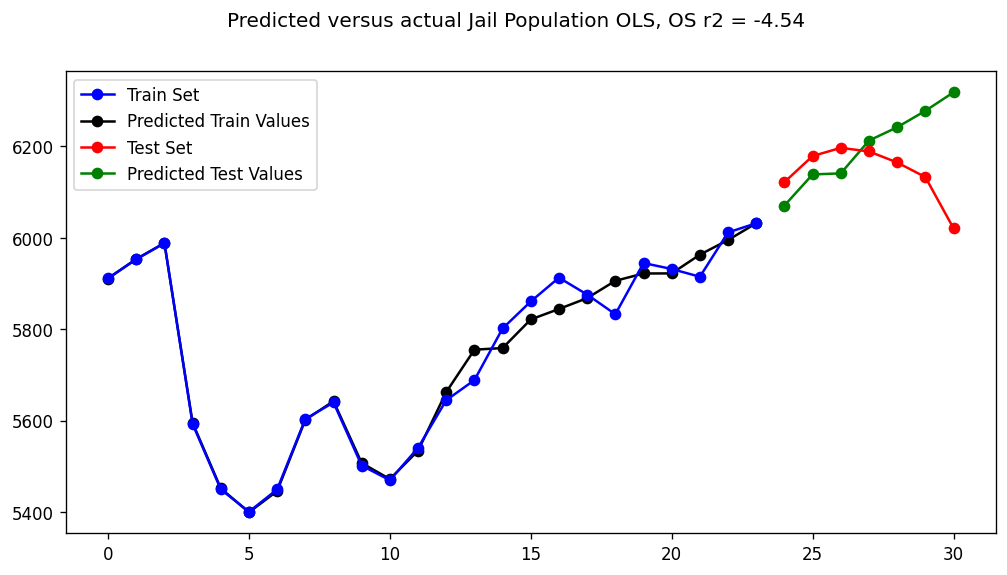

In [ ]:
#plot the predicted counts versus the actual counts for the test data
IS_predicted_counts = model.predict(X_train)
OS_predicted_counts = model.predict(X_test)
OS_r2 = r2_score(y_test, OS_predicted_counts)
actual_counts = y_test
fig = plt.figure()
fig.suptitle(f'Predicted versus actual Jail Population OLS, OS r2 = {OS_r2.round(2)}')
predicted_train, = plt.plot(X_train.index, IS_predicted_counts, 'ko-', label='Predicted Train Values')
train_set, = plt.plot(X_train.index, y_train, 'bo-', label='Train Set')
predicted_test, = plt.plot(range(len(X_train),len(X_train)+len(X_test)), OS_predicted_counts, 'go-', label='Predicted Test Values')
test_set, = plt.plot(range(len(X_train),len(X_train)+len(X_test)), actual_counts, 'ro-', label='Test Set')
plt.legend(handles=[train_set,predicted_train, test_set, predicted_test])
plt.show()

In [ ]:
# interval_data = interval_data[['Start Date','End Date',	'ADP','adp_lag1','adp_lag2','adp_lag7']]
# Calculate the rolling variance with a window of 5 data points
for i in range(5,12):
    interval_data['var_lag'+str(i)] = interval_data['ADP'].rolling(window=i).var()
    # interval_data['MA_lag'+str(i)] = interval_data['ADP'].rolling(window=i).mean()

interval_data = interval_data.fillna(0)
interval_data.head()

,Start Date,End Date,ADP,Month,Year,Holiday,adp_lag1,adp_lag2,adp_lag3,adp_lag4,...,adp_lag10,adp_lag11,adp_lag12,var_lag5,var_lag6,var_lag7,var_lag8,var_lag9,var_lag10,var_lag11
0,2021-06-30 00:00:00-04:00,2021-07-29 00:00:00-04:00,5912.0,6,2021,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-07-30 00:00:00-04:00,2021-08-28 00:00:00-04:00,5953.0,7,2021,1,5912.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-08-29 00:00:00-04:00,2021-09-27 00:00:00-04:00,5989.0,8,2021,0,5953.0,5912.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-09-28 00:00:00-04:00,2021-10-27 00:00:00-04:00,5593.0,9,2021,1,5989.0,5953.0,5912.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-10-28 00:00:00-04:00,2021-11-26 00:00:00-05:00,5450.0,10,2021,1,5593.0,5989.0,5953.0,5912.0,...,0.0,0.0,0.0,58725.3,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_train = interval_data.iloc[:train_size]
df_test = interval_data.iloc[train_size:]

print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

#scale the dataset for all variables to be within the same range of values, 0 to 1.
sc = MinMaxScaler()
df_train_sc = sc.fit_transform(df_train.drop(columns=['Start Date','End Date']))
df_test_sc = sc.transform(df_test.drop(columns=['Start Date','End Date']))
#convert these arrays to dfs
df_train_sc = pd.DataFrame(data=df_train_sc, columns=df_train.columns.to_list()[2:])
df_test_sc = pd.DataFrame(data=df_test_sc, columns=df_train.columns.to_list()[2:])

Training data set length=24
Testing data set length=7


In [ ]:
df_train_sc.head(13)

,ADP,Month,Year,Holiday,adp_lag1,adp_lag2,adp_lag3,adp_lag4,adp_lag5,adp_lag6,...,adp_lag10,adp_lag11,adp_lag12,var_lag5,var_lag6,var_lag7,var_lag8,var_lag9,var_lag10,var_lag11
0,0.809826,0.454545,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.874802,0.545455,0.0,1.0,0.983367,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.931854,0.636364,0.0,0.0,0.990186,0.987143,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.304279,0.727273,0.0,1.0,0.996174,0.993989,0.987143,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.077655,0.818182,0.0,1.0,0.930306,1.000000,0.993989,0.987143,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.761972,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.909091,0.0,1.0,0.906520,0.933879,1.000000,0.993989,0.987143,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.077655,1.000000,0.0,1.0,0.898370,0.910002,0.933879,1.000000,0.993989,0.987143,...,0.000000,0.000000,0.000000,0.756561,0.991740,1.000000,0.000000,0.000000,0.000000,0.000000
7,0.321712,0.000000,0.5,1.0,0.906520,0.901820,0.910002,0.933879,1.000000,0.993989,...,0.000000,0.000000,0.000000,0.111149,0.660202,0.849030,1.000000,0.000000,0.000000,0.000000
8,0.378764,0.090909,0.5,0.0,0.932136,0.910002,0.901820,0.910002,0.933879,1.000000,...,0.000000,0.000000,0.000000,0.145361,0.143107,0.570632,0.839334,1.000000,0.000000,0.000000
9,0.160063,0.181818,0.5,0.0,0.938124,0.935715,0.910002,0.901820,0.910002,0.933879,...,0.000000,0.000000,0.000000,0.132474,0.126623,0.123053,0.580052,0.875226,1.000000,0.000000


In [ ]:
X_train, y_train = df_train_sc.drop(columns=['ADP']), df_train_sc['ADP']
X_test, y_test = df_test_sc.drop(columns=['ADP']),df_test_sc['ADP']

#fit linear regression model
model = sm.OLS(y_train,X_train).fit()

#view model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    ADP   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              18.89
Date:                Tue, 16 Jan 2024   Prob (F-statistic):                      0.0514
Time:                        12:06:50   Log-Likelihood:                          40.828
No. Observations:                  24   AIC:                                     -37.66
Df Residuals:                       2   BIC:                                     -11.74
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

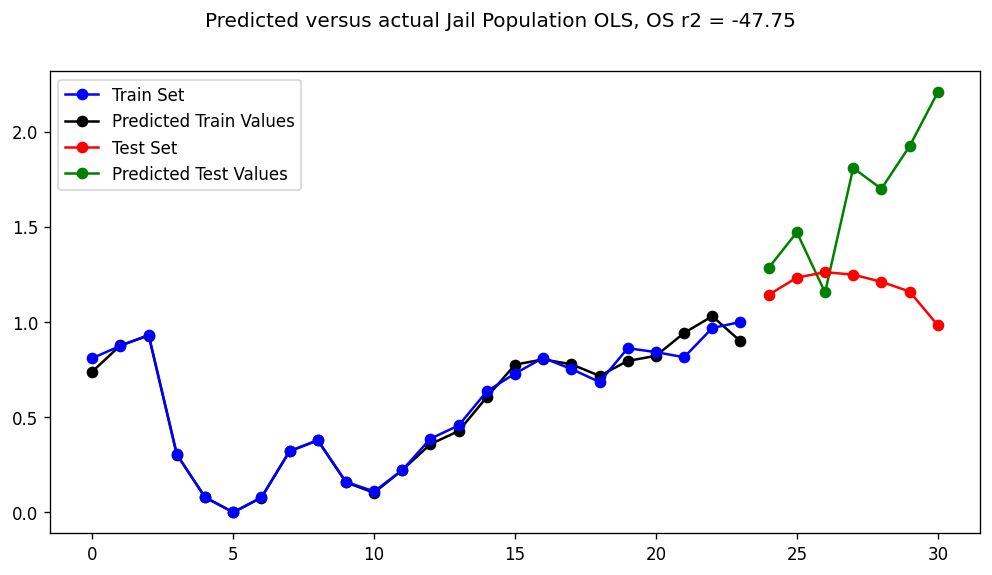

In [ ]:
#plot the predicted counts versus the actual counts for the test data
IS_predicted_counts = model.predict(X_train)
OS_predicted_counts = model.predict(X_test)
OS_r2 = r2_score(y_test, OS_predicted_counts)
actual_counts = y_test
fig = plt.figure()
fig.suptitle(f'Predicted versus actual Jail Population OLS, OS r2 = {OS_r2.round(2)}')
predicted_train, = plt.plot(X_train.index, IS_predicted_counts, 'ko-', label='Predicted Train Values')
train_set, = plt.plot(X_train.index, y_train, 'bo-', label='Train Set')
predicted_test, = plt.plot(range(len(X_train),len(X_train)+len(X_test)), OS_predicted_counts, 'go-', label='Predicted Test Values')
test_set, = plt.plot(range(len(X_train),len(X_train)+len(X_test)), actual_counts, 'ro-', label='Test Set')
plt.legend(handles=[train_set,predicted_train, test_set, predicted_test])
plt.show()

### Exponential Smoothing

We have tried to fit our data to an ARIMA and linear regression model, so far the ARIMA model predicts unforseen datapoints better than the linear regression.

### Simple Exponential Smoothing

Excerpt from https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/ :


Single Exponential Smoothing, SES for short, also called Simple Exponential Smoothing, is a time series forecasting method for univariate data without a trend or seasonality. It requires a single parameter, called alpha ($\alpha$), also called the smoothing factor or smoothing coefficient. This parameter controls the rate at which the influence of the observations at prior time steps decay exponentially. Alpha is often set to a value between 0 and 1. Large values mean that the model pays attention mainly to the most recent past observations, whereas smaller values mean more of the history is taken into account when making a prediction.


In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
# prepare data
series = _30day_pop_tot['ADP']
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# create class
model = SimpleExpSmoothing(train)
# fit model
model_fit = model.fit(smoothing_level=None, optimized=True)
#get insample 
insample = model_fit.predict(start = 0, end = len(train)-1)
is_mse = mean_squared_error(train, insample)
# make prediction
ypred = model_fit.predict(start = len(train), end = len(series)-1)
os_mse = mean_squared_error(test, ypred)

# get optimized alpha
optimized_alpha = model_fit.params['smoothing_level']
print(f"Optimized Alpha Value: {optimized_alpha}")

Optimized Alpha Value: 0.995


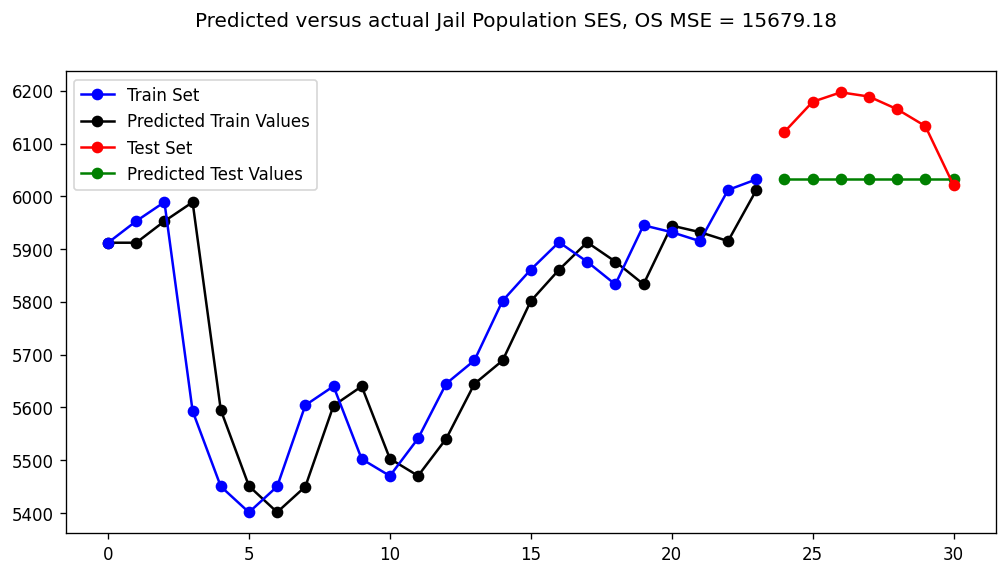

In [ ]:
#plot
fig = plt.figure()
fig.suptitle(f'Predicted versus actual Jail Population SES, OS MSE = {os_mse.round(2)}')
predicted_train, = plt.plot(train.index, insample, 'ko-', label='Predicted Train Values')
train_set, = plt.plot(train.index, train, 'bo-', label='Train Set')
predicted_test, = plt.plot(range(len(train),len(train)+len(test)), ypred, 'go-', label='Predicted Test Values')
test_set, = plt.plot(range(len(train),len(train)+len(test)), test, 'ro-', label='Test Set')
plt.legend(handles=[train_set,predicted_train, test_set, predicted_test])
plt.show()

### Double Exponential Smoothing

Double Exponential Smoothing is an extension to Exponential Smoothing that explicitly adds support for trends in the univariate time series. In addition to the alpha parameter for controlling smoothing factor for the level, an additional smoothing factor is added to control the decay of the influence of the change in trend called beta ($\beta$).The method supports trends that change in different ways: an additive and a multiplicative, depending on whether the trend is linear or exponential respectively. Double Exponential Smoothing with an additive trend is classically referred to as Holt’s linear trend model, named for the developer of the method Charles Holt.

* Additive Trend: Double Exponential Smoothing with a linear trend.

* Multiplicative Trend: Double Exponential Smoothing with an exponential trend.

#### Hyperparameters:

**Alpha:** Smoothing factor for the level.

**Beta:** Smoothing factor for the trend.

**Trend Type:** Additive or multiplicative.

**Dampen Type:** Additive or multiplicative.

**Phi:** Damping coefficient.

In [ ]:
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# define the parameter grid
alphas = np.arange(0.1,1,.05)
betas = np.arange(0.1,1,.05)
trend_types = ['add', 'multiplicative']
dampen_types = ['add', 'multiplicative']
phis = np.arange(0.1,1,.05)

# perform grid search
best_params = None
best_mse = float('inf')

for alpha, beta, trend_type, dampen_type, phi in product(alphas, betas, trend_types, dampen_types, phis):
    model = ExponentialSmoothing(train, trend=trend_type, damped_trend=dampen_type)
    model_fit = model.fit(smoothing_level=alpha, smoothing_trend=beta, damping_trend=phi)

    # get insample predictions
    insample = model_fit.fittedvalues
    is_mse = mean_squared_error(train, insample)

    # make prediction
    ypred = model_fit.predict(start=len(train), end=len(series)-1)
    os_mse = mean_squared_error(test, ypred)

    # update best parameters if the current model has lower MSE
    if os_mse < best_mse:
        best_mse = os_mse
        best_params = {'alpha': alpha, 'beta': beta, 'trend_type': trend_type, 'dampen_type': dampen_type, 'phi': phi}

print("Best Parameters:")
print(best_params)


Best Parameters:
{'alpha': 0.1, 'beta': 0.1, 'trend_type': 'multiplicative', 'dampen_type': 'add', 'phi': 0.8500000000000002}


In [ ]:
np.arange(0.1,1,.05)

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [ ]:
#what results do we get without optimizing hyperparameters
model = ExponentialSmoothing(train)
model_fit = model.fit(optimized=True)

# get insample predictions
insample = model_fit.fittedvalues
is_mse = mean_squared_error(train, insample)

# make prediction
ypred = model_fit.predict(start=len(train), end=len(series)-1)
os_mse = mean_squared_error(test, ypred)

In [ ]:
# get optimized alpha
print(model_fit.params)
print(f"OS MSE: {os_mse}")

{'smoothing_level': 0.995, 'smoothing_trend': nan, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 5925.53333333333, 'initial_trend': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
OS MSE: 15679.18039963493


In [ ]:
print(best_mse)

2723.6287532813362


In [ ]:
#re-define optimized model
best_params = {'alpha': 0.1, 'beta': 0.1, 'trend_type': 'multiplicative', 'dampen_type': 'add', 'phi': 0.8500000000000002}
model_cv = ExponentialSmoothing(train, trend=best_params['trend_type'], damped_trend=best_params['dampen_type'])
model_cv_fit = model_cv.fit(smoothing_level=best_params['alpha'], smoothing_trend=best_params['beta'], damping_trend=best_params['phi'])

# get insample predictions
insample_cv = model_cv_fit.fittedvalues
is_mse_cv = mean_squared_error(train, insample_cv)

# make prediction
ypred_cv = model_cv_fit.predict(start=len(train), end=len(series)-1)
os_mse_cv = mean_squared_error(test, ypred_cv)
print(os_mse_cv)

2723.6287532813362


In [ ]:
model_cv_fit.params

{'smoothing_level': 0.1,
 'smoothing_trend': 0.1,
 'smoothing_seasonal': nan,
 'damping_trend': 0.8500000000000002,
 'initial_level': 5925.53333333333,
 'initial_trend': 1.1679923524465836,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

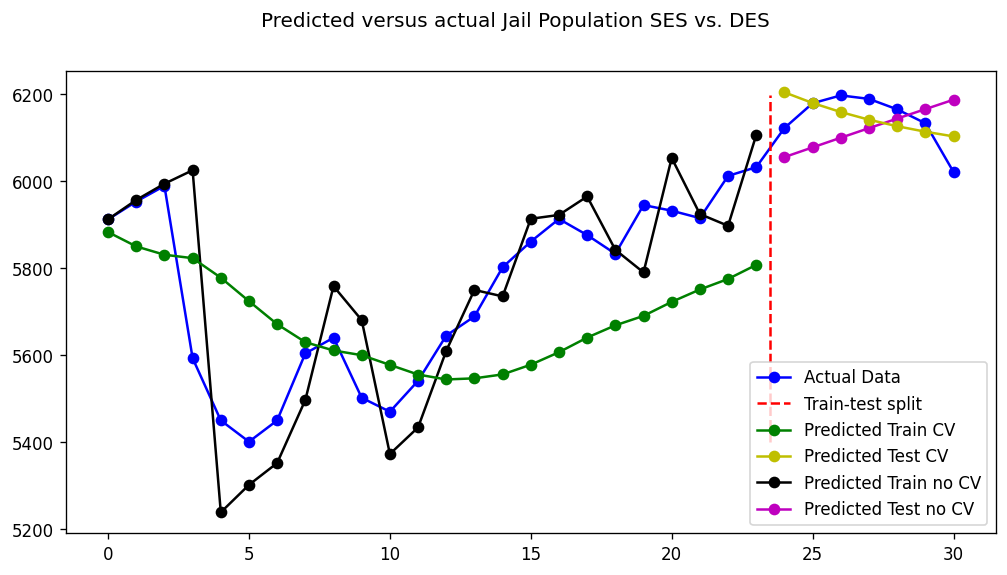

In [ ]:
# plot
fig = plt.figure()
fig.suptitle(f'Predicted versus actual Jail Population SES vs. DES')

# actual data
data, = plt.plot(series.index, series, 'bo-', label='Actual Data')

# train-test split line
test_split = plt.vlines(x=len(train)-0.5, ymin=min(series), ymax=max(series), colors='red', linestyles='--', label='Train-test split')

# model 1
predicted_train_no_cv, = plt.plot(train.index, insample, 'ko-', label='Predicted Train no CV')
predicted_test_no_cv, = plt.plot(range(len(train), len(train) + len(test)), ypred, 'mo-', label='Predicted Test no CV')

# model 2
predicted_train_cv, = plt.plot(train.index, insample_cv, 'go-', label='Predicted Train CV')
predicted_test_cv, = plt.plot(range(len(train), len(train) + len(test)), ypred_cv, 'yo-', label='Predicted Test CV')

# Add legend for the LineCollection
plt.legend(handles=[data, test_split, predicted_train_cv, predicted_test_cv, predicted_train_no_cv, predicted_test_no_cv])

plt.show()


In [ ]:
#try again and focus on higher alpha and beta parameters
# define the parameter grid
alphas = np.arange(0.8,1,.01)
betas = np.arange(0.8,1,.01)
trend_types = ['add', 'multiplicative']
dampen_types = ['add', 'multiplicative']
phis = np.arange(0.8,1,.01)

# perform grid search
best_params = None
best_mse = float('inf')

for alpha, beta, trend_type, dampen_type, phi in product(alphas, betas, trend_types, dampen_types, phis):
    model = ExponentialSmoothing(train, trend=trend_type, damped_trend=dampen_type)
    model_fit = model.fit(smoothing_level=alpha, smoothing_trend=beta, damping_trend=phi)

    # get insample predictions
    insample = model_fit.fittedvalues
    is_mse = mean_squared_error(train, insample)

    # make prediction
    ypred = model_fit.predict(start=len(train), end=len(series)-1)
    os_mse = mean_squared_error(test, ypred)

    # update best parameters if the current model has lower MSE
    if os_mse < best_mse:
        best_mse = os_mse
        best_params = {'alpha': alpha, 'beta': beta, 'trend_type': trend_type, 'dampen_type': dampen_type, 'phi': phi}

print("Best Parameters:")
print(best_params)

Best Parameters:
{'alpha': 0.8400000000000001, 'beta': 0.9900000000000002, 'trend_type': 'add', 'dampen_type': 'add', 'phi': 0.8}


In [ ]:
#fit this model and plot with others
best_params = {'alpha': 0.8400000000000001, 'beta': 0.9900000000000002, 'trend_type': 'add', 'dampen_type': 'add', 'phi': 0.8}
model_cv2 = ExponentialSmoothing(train, trend=best_params['trend_type'], damped_trend=best_params['dampen_type'])
model_cv_fit2 = model_cv2.fit(smoothing_level=best_params['alpha'], smoothing_trend=best_params['beta'], damping_trend=best_params['phi'])

# get insample predictions
insample_cv2 = model_cv_fit2.fittedvalues
is_mse_cv2 = mean_squared_error(train, insample_cv2)

# make prediction
ypred_cv2 = model_cv_fit2.predict(start=len(train), end=len(series)-1)
os_mse_cv2 = mean_squared_error(test, ypred_cv2)
print(os_mse_cv2)

5939.805192782953


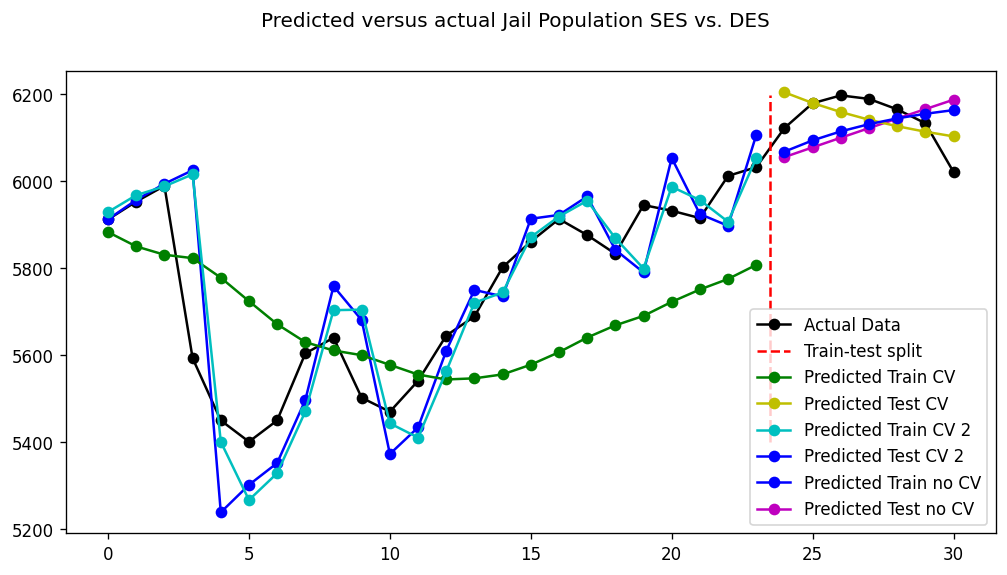

In [ ]:
#plot
# plot
fig = plt.figure()
fig.suptitle(f'Predicted versus actual Jail Population SES vs. DES')

# actual data
data, = plt.plot(series.index, series, 'ko-', label='Actual Data')

# train-test split line
test_split = plt.vlines(x=len(train)-0.5, ymin=min(series), ymax=max(series), colors='red', linestyles='--', label='Train-test split')

# model 1
predicted_train_no_cv, = plt.plot(train.index, insample, 'bo-', label='Predicted Train no CV')
predicted_test_no_cv, = plt.plot(range(len(train), len(train) + len(test)), ypred, 'mo-', label='Predicted Test no CV')

# model 2
predicted_train_cv, = plt.plot(train.index, insample_cv, 'go-', label='Predicted Train CV')
predicted_test_cv, = plt.plot(range(len(train), len(train) + len(test)), ypred_cv, 'yo-', label='Predicted Test CV')

# model 3
predicted_train_cv2, = plt.plot(train.index, insample_cv2, 'co-', label='Predicted Train CV 2')
predicted_test_cv2, = plt.plot(range(len(train), len(train) + len(test)), ypred_cv2, 'bo-', label='Predicted Test CV 2')

# Add legend for the LineCollection
plt.legend(handles=[data, test_split, predicted_train_cv, predicted_test_cv,predicted_train_cv2, predicted_test_cv2, predicted_train_no_cv, predicted_test_no_cv])

plt.show()


Based on the results above, I'd say the second optimization of the DES and the regular SES are the two best models for predicting our ADP.

### Triple Exponential Smoothing

Triple Exponential Smoothing is an extension of Exponential Smoothing that explicitly adds support for seasonality to the univariate time series. This method is sometimes called Holt-Winters Exponential Smoothing, named for two contributors to the method: Charles Holt and Peter Winters. In addition to the alpha and beta smoothing factors, a new parameter is added called gamma ($\gamma$) that controls the influence on the seasonal component. As with the trend, the seasonality may be modeled as either an additive or multiplicative process for a linear or exponential change in the seasonality.

**Additive Seasonality:** Triple Exponential Smoothing with a linear seasonality.

**Multiplicative Seasonality:** Triple Exponential Smoothing with an exponential seasonality.

#### Hyperparameters:

**Alpha:** Smoothing factor for the level.

**Beta:** Smoothing factor for the trend.

**Trend Type:** Additive or multiplicative.

**Dampen Type:** Additive or multiplicative.

**Phi:** Damping coefficient.

**Seasonality Type:** Additive or multiplicative.

**Gamma**: Seasonal Dampening coefficient

**Period:** Time steps in seasonal period.

In [ ]:
# #redo optimization but add seasonality type to the parameters. We know if there is a period it should be 12 because the data is monthly. 
# #try again and focus on higher alpha and beta parameters
# # define the parameter grid
# alphas = np.arange(0.8,1,.01)
# betas = np.arange(0.8,1,.01)
# trend_types = ['add', 'multiplicative']
# dampen_types = ['add', 'multiplicative']
# phis = np.arange(0.8,1,.01)
# seasonal_type = ['add', 'multiplicative']
# gamma = np.arange(0,1,.1)

# # perform grid search
# best_params = None
# best_mse = float('inf')

# for alpha, beta, trend_type, dampen_type, seasonal_type, phi, gamma in product(alphas, betas, trend_types, dampen_types, seasonal_type, phis, gamma):
#     try:
#         #seasonal period will always be 12 for a ts sampled monthly
#         model = ExponentialSmoothing(train, trend=trend_type, damped_trend=dampen_type, seasonal=seasonal_type, seasonal_periods = 12)
#         model_fit = model.fit(smoothing_level=alpha, smoothing_trend=beta, damping_trend=phi, smoothing_seasonal = gamma)

#         # get insample predictions
#         insample = model_fit.fittedvalues
#         is_mse = mean_squared_error(train, insample)

#         # make prediction
#         ypred = model_fit.predict(start=len(train), end=len(series)-1)
#         os_mse = mean_squared_error(test, ypred)

#         # update best parameters if the current model has lower MSE
#         if os_mse < best_mse:
#             best_mse = os_mse
#             best_params = {'alpha': alpha, 'beta': beta, 'trend_type': trend_type, 'dampen_type': dampen_type, 'phi': phi}
#     except:
#         print(f'The following parameters did not work, alpha: {alpha}, beta: {beta}, trend_type: {trend_type}, dampen_type: {dampen_type}, phi: {phi}')
# print("Best Parameters:")
# print(best_params)